## Import libraries

In [40]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..', '..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import facts
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report,print_recourse_report_KStest_cumulative,print_recourse_report_cumulative
from facts.utils import load_rules_by_if,save_rules_by_if
from facts.utils import load_rules_by_if,save_rules_by_if

import matplotlib.pyplot as plt

In [41]:
from pathlib import Path

computed_rules_file = Path("..") / ".." / "Pre-computed Results" / "IBM_AdCampaign" / "rulesAdCampaign_atomic.data"
computed_rules_with_cumulative_file = Path("..") / ".." / "Pre-computed Results" / "IBM_AdCampaign" / "rulesAdCampaign_cumulative.data"

In [47]:
DATAFILE = '../../../ad_campaign_data.csv' # location of dataset
random_state = None # change to something for exactly reproducible results
random_seed = 131313

# as selected in "tutorial_bias_advertising" notebook
selected_features = ['religion','politics','gender', 'parents', 'ages', 'income', 'area', 'college_educated', 'homeowner']
cate_features = ['religion','politics','gender', 'parents', 'ages', 'income', 'area', 'college_educated']
num_features = ['homeowner']

# if not specified, set to 1
feature_weights = {"gender": 1, "parents": 1, "age": 1}

target_name = "true_conversion"
positive_label = 1
negative_label = 0

model_train_fraction = 0.7
learning_class_weights = {0: 0.5, 1: 265}

sensitive_attribute = "gender"
sensitive_alias = {"M": "Male", "F": "Female", "Unknown": "Unknown"}

## Load Dataset

In [43]:
ad_conversion_dataset = pd.read_csv(DATAFILE)
ad_conversion_dataset.head()

,religion,politics,college_educated,parents,homeowner,gender,age,income,area,true_conversion,predicted_conversion,predicted_probability
0,Unknown,Unknown,1,1,1,Unknown,55-64,Unknown,Unknown,0,0,0.001351
1,Other,Unknown,1,1,1,Unknown,55-64,Unknown,Urban,0,0,0.002238
2,Unknown,Unknown,1,1,1,F,55-64,Unknown,Unknown,0,0,0.002704
3,Unknown,Unknown,1,1,1,F,55-64,Unknown,Unknown,0,0,0.001967
4,Unknown,Unknown,1,1,1,F,55-64,Unknown,Urban,0,0,0.001681


In [44]:
ad_conversion_dataset.gender = ad_conversion_dataset.gender.map(sensitive_alias)
ad_conversion_dataset.rename(columns = {'age':'ages'}, inplace = True)


# Preprocessing

In [45]:
## keep only the columns in selected_features, plus the label column
ad_conversion_dataset = ad_conversion_dataset[selected_features + [target_name]]
ad_conversion_dataset

,religion,politics,gender,parents,ages,income,area,college_educated,homeowner,true_conversion
0,Unknown,Unknown,Unknown,1,55-64,Unknown,Unknown,1,1,0
1,Other,Unknown,Unknown,1,55-64,Unknown,Urban,1,1,0
2,Unknown,Unknown,Female,1,55-64,Unknown,Unknown,1,1,0
3,Unknown,Unknown,Female,1,55-64,Unknown,Unknown,1,1,0
4,Unknown,Unknown,Female,1,55-64,Unknown,Urban,1,1,0
...,...,...,...,...,...,...,...,...,...,...
1443135,Other,Unknown,Female,1,25-34,Unknown,Unknown,1,1,0
1443136,Unknown,Unknown,Female,1,55-64,Unknown,Unknown,1,0,0
1443137,Unknown,Unknown,Unknown,1,55-64,Unknown,Unknown,1,1,0
1443138,Unknown,Unknown,Female,1,55-64,Unknown,Unknown,1,1,0


In [49]:
## train-test split

X = ad_conversion_dataset.drop(target_name, axis=1)
y = ad_conversion_dataset[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=model_train_fraction, random_state=random_seed, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Model training

In [25]:
%%time

model = customLogisticRegression(class_weight=learning_class_weights)
model.fit(X_train, y_train, cate_columns=cate_features, target_column=target_name)
model.predict(X_test.iloc[:100, :])

Wall time: 34.6 s


c:\Users\Nikolas Theol\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

# Testing the model

We check if the model is satisfactory.

In [26]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       1.00      0.90      0.94    432231
           1       0.00      0.11      0.00       712

    accuracy                           0.89    432943
   macro avg       0.50      0.50      0.47    432943
weighted avg       1.00      0.89      0.94    432943



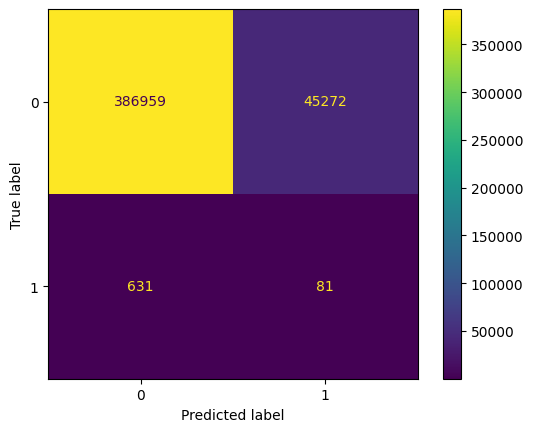

In [27]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Macro Viewpoint

# Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [28]:
# #Uncomment if you want to find new rules with different support

# ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
#     X_test,
#     model=model,
#     sensitive_attribute='gender',
#     freqitem_minsupp = 0.01,
#     missing_subgroup_val="Unknown",
#     drop_infeasible = True,
#     drop_above = False
# )

# print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
# rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

In [29]:
from facts.utils import load_rules_by_if, save_rules_by_if

## Use this for loading rules from disk
rules_by_if = load_rules_by_if(computed_rules_file)

## Use this for saving rules on disk
#save_rules_by_if(precomputed_rules_file, rules_by_if)

In [30]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["Male"][1][0][1]-e[1]["Female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If ages = 55-64, area = Urban, college_educated = 1, homeowner = 1, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 15.09% covered
		Make religion = Christianity with correctness 100.00%.
		Make religion = Other with correctness 100.00%.
		Make area = Rural, religion = Other with correctness 100.00%.
		Make area = Rural, religion = Christianity with correctness 100.00%.
	Protected Subgroup 'Female', 13.68% covered
		Make religion = Christianity with correctness 0.00%.
		Make religion = Other with correctness 0.00%.
		Make area = Rural, religion = Other with correctness 0.00%.
		Make area = Rural, religion = Christianity with correctness 0.00%.
If ages = 55-64, area = Urban, college_educated = 1, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 15.09% covered
		Make religion = Christianity with correctness 100.00%.
		Make religion = Other with correctness 100.00%.
		Make area = Rural, re

In [31]:
num_features = []
cate_features = ['religion','politics', 'parents', 'ages', 'income', 'area', 'college_educated', 'homeowner']
ord_features = []

feature_weights = {'religion':5,'politics':2, 'parents':3, 'ages':10, 'income':3, 'area':2, 'college_educated':3, 'homeowner':1}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = facts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=False,
)
params = ParameterProxy(featureChanges=comparators)

## Macro Viewpoint

### Equal Cost of Effectiveness (Macro)

In [32]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",        
        "remove-fair-rules",
        "keep-only-min-change"
    ],
    cor_threshold=0.5,
    secondary_sorting_objectives=[
        # "min-group-cost",
        "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["gender"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["gender"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If homeowner = 1, parents = 0:
	Protected Subgroup 'Male', 5.74% covered out of 83563
		Make homeowner = 0 with effectiveness 51.94%.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Female', 5.25% covered out of 162105
		Make homeowner = 0, parents = 1 with effectiveness 96.52%.
		Aggregate cost of the above recourses = 4.00
	Bias against Female due to Equal Effectiveness. Unfairness score = 3.
If college_educated = 1, homeowner = 1, parents = 0:
	Protected Subgroup 'Male', 5.41% covered out of 83563
		Make homeowner = 0 with effectiveness 52.13%.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Female', 4.97% covered out of 162105
		Make homeowner = 0, parents = 1 with effectiveness 96.60%.
		Aggregate cost of the above recourses = 4.00
	Bias against Female due to Equal Effectiveness. Unfairness score = 3.


### Equal Choice for Recourse

In [33]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        # "remove-fair-rules"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["gender"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["gender"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If area = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 53.09% covered out of 83563
		Make area = Urban, religion = Christianity with effectiveness 85.47%.
		Make area = Urban, religion = Other with effectiveness 85.47%.
		Make area = Rural, religion = Christianity with effectiveness 90.52%.
		Make area = Rural, religion = Other with effectiveness 90.52%.
		Aggregate cost of the above recourses = -4.00
	Protected Subgroup 'Female', 48.86% covered out of 162105
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.00
	Bias against Female due to Equal Effectiveness. Unfairness score = 4.
If area = Unknown, homeowner = 1, religion = Unknown:
	Protected Subgroup 'Male', 51.81% covered out of 83563
		Make homeowner = 0 with effectiveness 90.59%.
		Make homeowner = 0, religion = Christianity with effectiveness 99.24%.
		Make homeowner = 0, religion = Other with effectiveness 99.27%.
		Make area = Urban, religion = Christianity with effectiveness 85.15%.
		M

## Micro viewpoint

We start by computing the cumulative effectiveness of the actions for each subgroup and each value of the protected attribute.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [34]:
## Use this for loading rules from disk
rules_with_cumulative = load_rules_by_if(computed_rules_with_cumulative_file)

## Use this for saving rules on disk
# save_rules_by_if(precomputed_rules_with_cumulative_file, rules_with_cumulative)

# facts.update_costs_cumulative(rules_with_cumulative, params)

### Equal (Conditional) Mean Recourse

If ages = 55-64, area = Unknown, college_educated = 1, income = Unknown, parents = 0, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 2.77% covered out of 83563
		Make parents = 1 with effectiveness 14.23% and counterfactual cost = 3.0.
		Make income = <100K, parents = 1 with effectiveness 14.23% and counterfactual cost = 6.0.
		Make college_educated = 0, parents = 1 with effectiveness 14.23% and counterfactual cost = 6.0.
		Make parents = 1, religion = Christianity with effectiveness 14.23% and counterfactual cost = 8.0.
		Make parents = 1, religion = Other with effectiveness 14.23% and counterfactual cost = 8.0.
		Make area = Urban, parents = 1, religion = Christianity with effectiveness 100.00% and counterfactual cost = 10.0.
		Make area = Urban, parents = 1, religion = Other with effectiveness 100.00% and counterfactual cost = 10.0.
		Make area = Rural, parents = 1, religion = Other with effectiveness 100.00% and counterfactual cost = 10.0.
		Make area = Rural, 

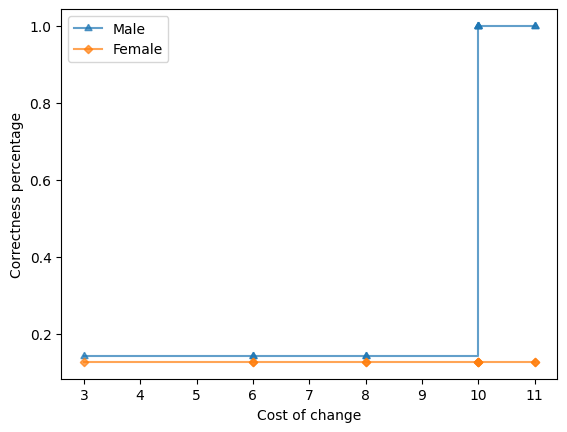

If ages = 55-64, area = Unknown, income = Unknown, parents = 0, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 2.95% covered out of 83563
		Make parents = 1 with effectiveness 14.28% and counterfactual cost = 3.0.
		Make income = <100K, parents = 1 with effectiveness 14.28% and counterfactual cost = 6.0.
		Make parents = 1, religion = Christianity with effectiveness 14.28% and counterfactual cost = 8.0.
		Make parents = 1, religion = Other with effectiveness 14.28% and counterfactual cost = 8.0.
		Make area = Urban, parents = 1, religion = Christianity with effectiveness 94.78% and counterfactual cost = 10.0.
		Make area = Urban, parents = 1, religion = Other with effectiveness 94.78% and counterfactual cost = 10.0.
		Make area = Rural, parents = 1, religion = Other with effectiveness 100.00% and counterfactual cost = 10.0.
		Make area = Rural, parents = 1, religion = Christianity with effectiveness 100.00% and counterfactual cost = 10.0.
		Make income = <100K, par

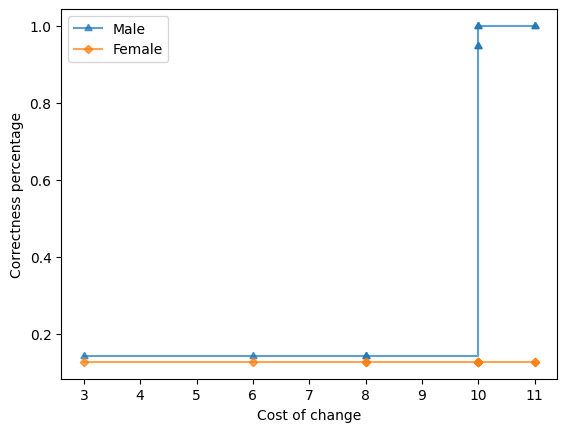

If ages = 55-64, area = Unknown, parents = 0, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 3.07% covered out of 83563
		Make parents = 1 with effectiveness 13.70% and counterfactual cost = 3.0.
		Make area = Urban, parents = 1 with effectiveness 16.41% and counterfactual cost = 5.0.
		Make parents = 1, religion = Christianity with effectiveness 16.41% and counterfactual cost = 8.0.
		Make parents = 1, religion = Other with effectiveness 16.41% and counterfactual cost = 8.0.
		Make area = Urban, parents = 1, religion = Christianity with effectiveness 93.64% and counterfactual cost = 10.0.
		Make area = Urban, parents = 1, religion = Other with effectiveness 93.64% and counterfactual cost = 10.0.
		Make area = Rural, parents = 1, religion = Christianity with effectiveness 98.64% and counterfactual cost = 10.0.
		Make area = Rural, parents = 1, religion = Other with effectiveness 98.64% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 8.89
	

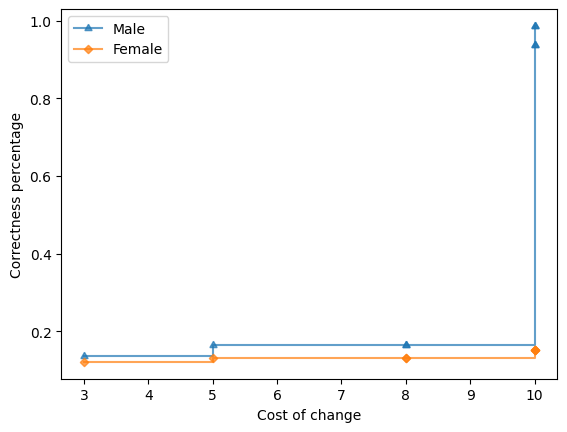

If ages = 55-64, area = Unknown, college_educated = 1, parents = 0, religion = Unknown:
	Protected Subgroup 'Male', 2.90% covered out of 83563
		Make parents = 1 with effectiveness 13.54% and counterfactual cost = 3.0.
		Make area = Urban, parents = 1 with effectiveness 16.32% and counterfactual cost = 5.0.
		Make college_educated = 0, parents = 1 with effectiveness 16.32% and counterfactual cost = 6.0.
		Make parents = 1, religion = Christianity with effectiveness 16.32% and counterfactual cost = 8.0.
		Make parents = 1, religion = Other with effectiveness 16.32% and counterfactual cost = 8.0.
		Make area = Urban, parents = 1, religion = Christianity with effectiveness 98.03% and counterfactual cost = 10.0.
		Make area = Urban, parents = 1, religion = Other with effectiveness 98.03% and counterfactual cost = 10.0.
		Make area = Rural, parents = 1, religion = Other with effectiveness 98.48% and counterfactual cost = 10.0.
		Make area = Rural, parents = 1, religion = Christianity with e

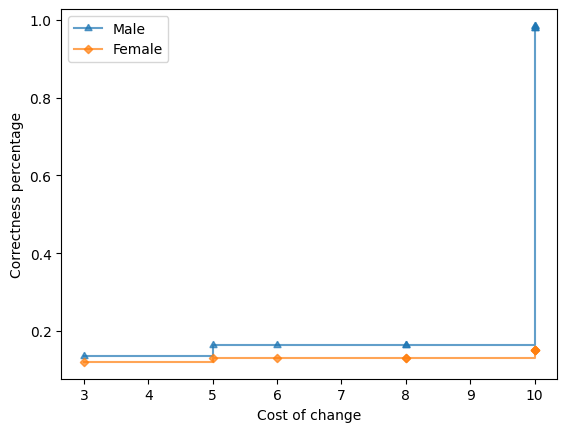

In [35]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="fairness-of-mean-recourse-conditional",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=10,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["gender"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["gender"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

### Equal Effectiveness

If ages = 55-64, area = Unknown, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 43.91% covered out of 83563
		Make income = <100K with effectiveness 0.00% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 94.30% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 94.30% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 100.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 100.00% and counterfactual cost = 7.0.
		Make income = <100K, religion = Christianity with effectiveness 100.00% and counterfactual cost = 8.0.
		Make income = <100K, religion = Other with effectiveness 100.00% and counterfactual cost = 8

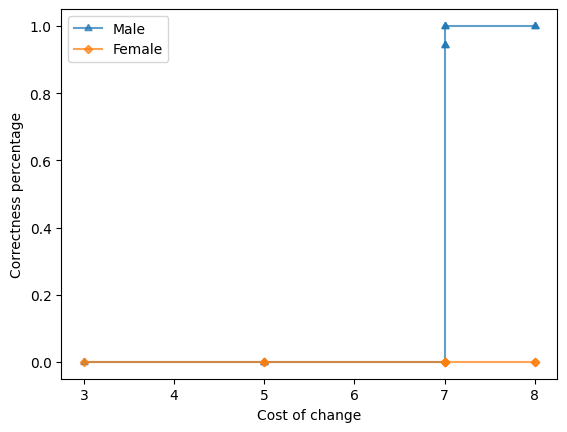

If ages = 55-64, area = Unknown, college_educated = 1, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 41.41% covered out of 83563
		Make income = <100K with effectiveness 0.00% and counterfactual cost = 3.0.
		Make college_educated = 0 with effectiveness 0.00% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 100.00% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 100.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 100.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 100.00% and counterfactual cost = 7.0.
		Make income = <100K, religion = Christianity with effectiveness 100.00% and counterfactua

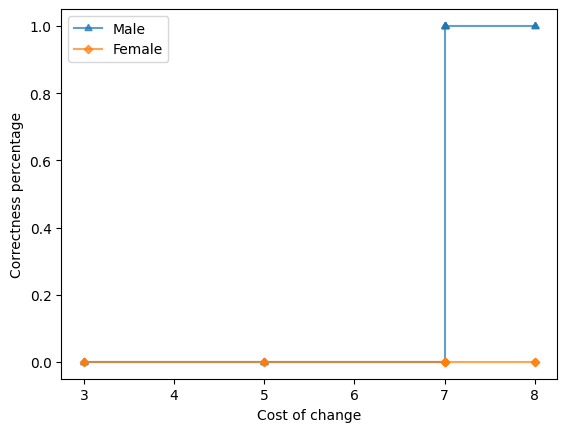

If ages = 55-64, area = Urban, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 16.00% covered out of 83563
		Make religion = Christianity with effectiveness 94.35% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 94.35% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 100.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 100.00% and counterfactual cost = 7.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Female', 14.50% covered out of 162105
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 0.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 0.00% and counterfactual cost = 7.0.
		Aggr

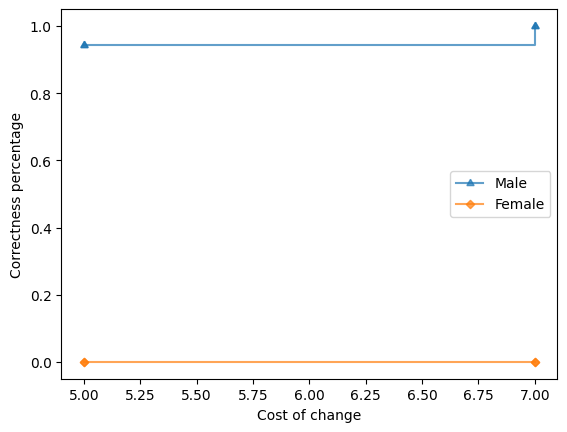

If ages = 55-64, area = Unknown, income = Unknown, parents = 1, politics = Unknown, religion = Christianity:
	Protected Subgroup 'Male', 10.31% covered out of 83563
		Make area = Urban with effectiveness 94.57% and counterfactual cost = 2.0.
		Make area = Rural with effectiveness 100.00% and counterfactual cost = 2.0.
		Make income = <100K with effectiveness 100.00% and counterfactual cost = 3.0.
		Make religion = Other with effectiveness 100.00% and counterfactual cost = 5.0.
		Make area = Urban, religion = Other with effectiveness 100.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 100.00% and counterfactual cost = 7.0.
		Make income = <100K, religion = Other with effectiveness 100.00% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Female', 9.57% covered out of 162105
		Make area = Urban with effectiveness 0.00% and counterfactual cost = 2.0.
		Make area = Rural with effectiveness 0.00% an

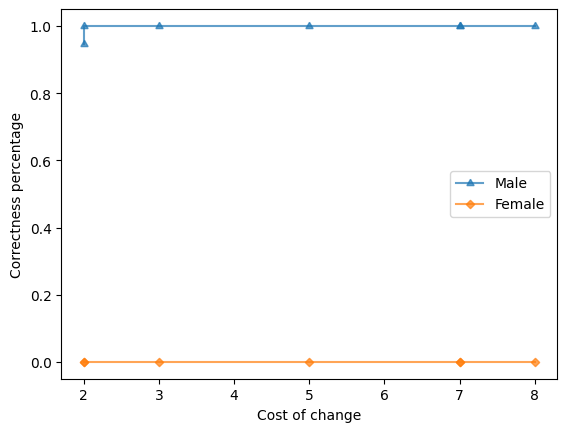

If ages = 55-64, area = Unknown, income = Unknown, parents = 1, politics = Unknown, religion = Other:
	Protected Subgroup 'Male', 9.66% covered out of 83563
		Make area = Urban with effectiveness 94.50% and counterfactual cost = 2.0.
		Make area = Rural with effectiveness 100.00% and counterfactual cost = 2.0.
		Make income = <100K with effectiveness 100.00% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 100.00% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 100.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 100.00% and counterfactual cost = 7.0.
		Make income = <100K, religion = Christianity with effectiveness 100.00% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Female', 8.67% covered out of 162105
		Make area = Urban with effectiveness 0.00% and counterfactual cost = 2.0.
		Make area = Rural with ef

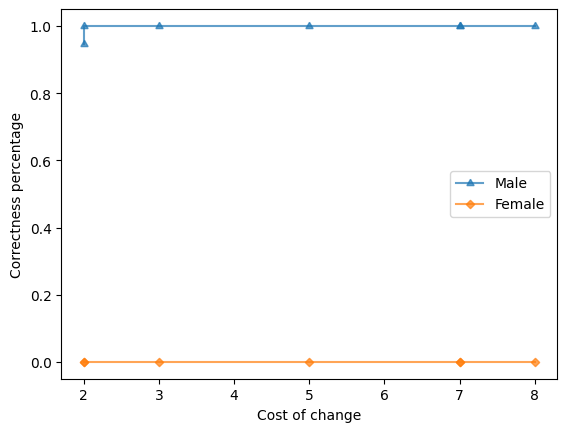

If ages = 55-64, area = Rural, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 3.42% covered out of 83563
		Make religion = Other with effectiveness 100.00% and counterfactual cost = 5.0.
		Make religion = Christianity with effectiveness 100.00% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 100.00% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 100.00% and counterfactual cost = 7.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Female', 3.03% covered out of 162105
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 0.00% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 0.00% and counterfactual cost = 7.0.
		Aggr

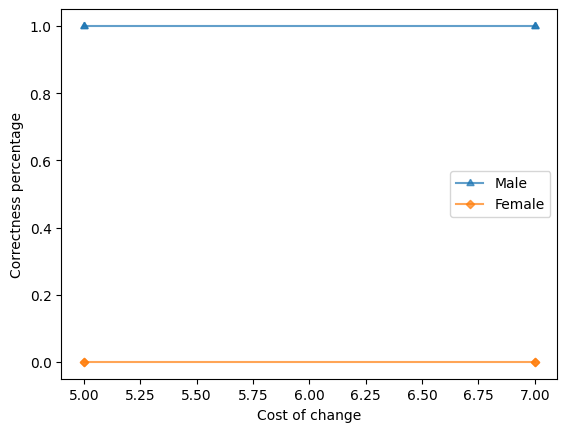

If ages = 55-64, area = Unknown, college_educated = 0, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 2.50% covered out of 83563
		Make college_educated = 1 with effectiveness 0.00% and counterfactual cost = 3.0.
		Make college_educated = 1, income = <100K with effectiveness 0.00% and counterfactual cost = 6.0.
		Make college_educated = 1, religion = Christianity with effectiveness 0.00% and counterfactual cost = 8.0.
		Make college_educated = 1, religion = Other with effectiveness 0.00% and counterfactual cost = 8.0.
		Make area = Urban, college_educated = 1, religion = Christianity with effectiveness 100.00% and counterfactual cost = 10.0.
		Make area = Urban, college_educated = 1, religion = Other with effectiveness 100.00% and counterfactual cost = 10.0.
		Make area = Rural, college_educated = 1, religion = Other with effectiveness 100.00% and counterfactual cost = 10.0.
		Make area = Rural, college_educated = 1, religion = Christ

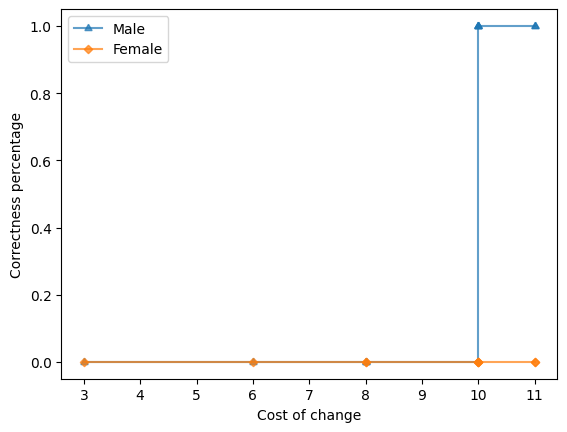

If ages = 55-64, area = Unknown, college_educated = 0, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 2.60% covered out of 83563
		Make college_educated = 1 with effectiveness 0.00% and counterfactual cost = 3.0.
		Make college_educated = 1, religion = Christianity with effectiveness 1.10% and counterfactual cost = 8.0.
		Make college_educated = 1, religion = Other with effectiveness 1.10% and counterfactual cost = 8.0.
		Make area = Urban, college_educated = 1, religion = Christianity with effectiveness 99.20% and counterfactual cost = 10.0.
		Make area = Urban, college_educated = 1, religion = Other with effectiveness 99.20% and counterfactual cost = 10.0.
		Make area = Rural, college_educated = 1, religion = Christianity with effectiveness 99.20% and counterfactual cost = 10.0.
		Make area = Rural, college_educated = 1, religion = Other with effectiveness 99.20% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.99
	Protecte

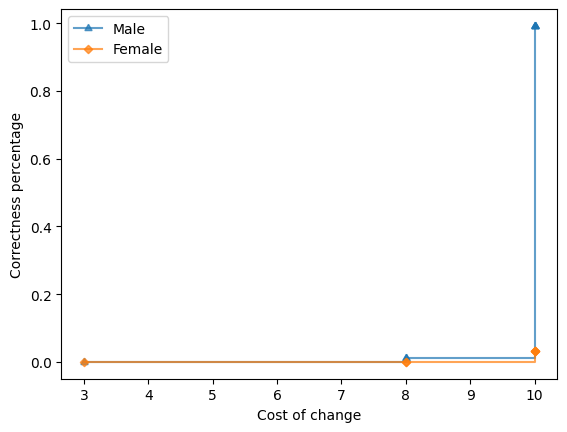

If ages = 55-64, area = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 46.07% covered out of 83563
		Make area = Urban with effectiveness 3.26% and counterfactual cost = 2.0.
		Make religion = Christianity with effectiveness 3.26% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 3.26% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 93.14% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 93.14% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 98.58% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 98.58% and counterfactual cost = 7.0.
		Aggregate cost of the above recourses = 0.99
	Protected Subgroup 'Female', 42.50% covered out of 162105
		Make area = Urban with effectiveness 1.12% and counterfactual cost = 2.0.
		Make religion = Christianity with eff

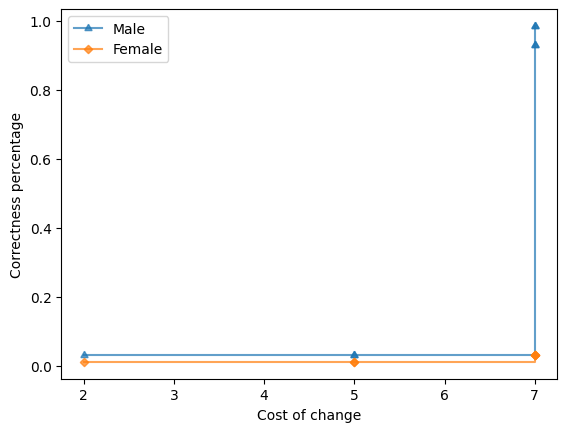

If ages = 55-64, area = Unknown, college_educated = 1, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 43.47% covered out of 83563
		Make college_educated = 0 with effectiveness 0.00% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 1.20% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 1.20% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 98.54% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 98.54% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 98.54% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 98.54% and counterfactual cost = 7.0.
		Aggregate cost of the above recourses = 0.99
	Protected Subgroup 'Female', 40.06% covered out of 162105
		Make college_educated = 0 with effectiveness 0.00% and counterfactual cost = 3.0.
	

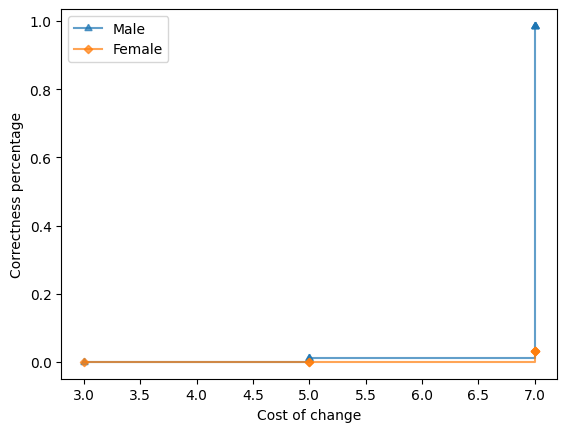

In [36]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="total-correctness",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules",
        # "keep-only-min-change"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["gender"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["gender"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric= True
)

### Equal Cost of Effectiveness (micro)

If ages = 55-64, income = Unknown, parents = 1, religion = Unknown:
	Protected Subgroup 'Male', 63.65% covered out of 83563
		Make income = <100K with effectiveness 30.52% and counterfactual cost = 3.0.
		Aggregate cost of the above recourses = 3.00
	Protected Subgroup 'Female', 58.32% covered out of 162105
		Make income = <100K with effectiveness 4.94% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 4.94% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 4.94% and counterfactual cost = 5.0.
		Make income = <100K, religion = Christianity with effectiveness 30.10% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 8.00
	Bias against Female due to Equal Effectiveness. Unfairness score = 5.0.
	Cumulative effectiveness plot for the above recourses:


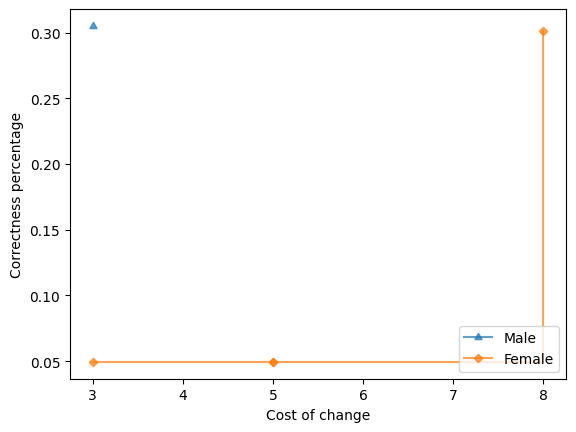

If ages = 55-64, college_educated = 1, income = Unknown, parents = 1, religion = Unknown:
	Protected Subgroup 'Male', 60.03% covered out of 83563
		Make college_educated = 0 with effectiveness 0.00% and counterfactual cost = 3.0.
		Make income = <100K with effectiveness 30.54% and counterfactual cost = 3.0.
		Aggregate cost of the above recourses = 3.00
	Protected Subgroup 'Female', 54.99% covered out of 162105
		Make college_educated = 0 with effectiveness 0.00% and counterfactual cost = 3.0.
		Make income = <100K with effectiveness 5.24% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 5.24% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 5.24% and counterfactual cost = 5.0.
		Make income = <100K, religion = Christianity with effectiveness 30.13% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 8.00
	Bias against Female due to Equal Effectiveness. Unfairness score = 5.0.
	Cumulative effectiveness plot f

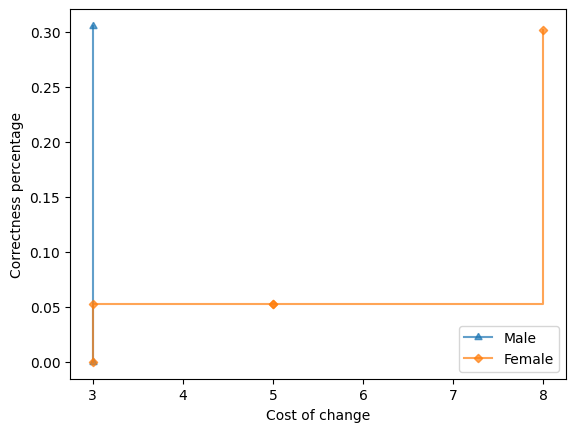

If income = Unknown, parents = 0, religion = Unknown:
	Protected Subgroup 'Male', 4.34% covered out of 83563
		Make parents = 1 with effectiveness 9.91% and counterfactual cost = 3.0.
		Make income = <100K, parents = 1 with effectiveness 36.46% and counterfactual cost = 6.0.
		Aggregate cost of the above recourses = 6.00
	Protected Subgroup 'Female', 3.93% covered out of 162105
		Make parents = 1 with effectiveness 9.04% and counterfactual cost = 3.0.
		Make income = <100K, parents = 1 with effectiveness 14.14% and counterfactual cost = 6.0.
		Make parents = 1, religion = Christianity with effectiveness 14.14% and counterfactual cost = 8.0.
		Make parents = 1, religion = Other with effectiveness 14.14% and counterfactual cost = 8.0.
		Make income = <100K, parents = 1, religion = Christianity with effectiveness 35.51% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Bias against Female due to Equal Effectiveness. Unfairness score = 5.0.
	Cumulative effect

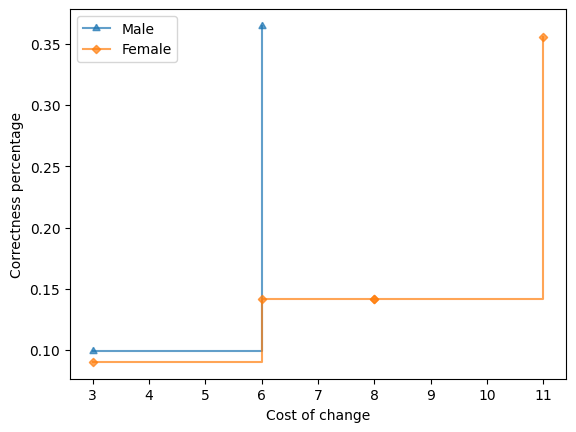

If college_educated = 1, income = Unknown, parents = 0, religion = Unknown:
	Protected Subgroup 'Male', 4.07% covered out of 83563
		Make parents = 1 with effectiveness 9.85% and counterfactual cost = 3.0.
		Make college_educated = 0, parents = 1 with effectiveness 9.85% and counterfactual cost = 6.0.
		Make income = <100K, parents = 1 with effectiveness 36.39% and counterfactual cost = 6.0.
		Aggregate cost of the above recourses = 6.00
	Protected Subgroup 'Female', 3.72% covered out of 162105
		Make parents = 1 with effectiveness 8.95% and counterfactual cost = 3.0.
		Make college_educated = 0, parents = 1 with effectiveness 8.95% and counterfactual cost = 6.0.
		Make income = <100K, parents = 1 with effectiveness 14.35% and counterfactual cost = 6.0.
		Make parents = 1, religion = Christianity with effectiveness 14.35% and counterfactual cost = 8.0.
		Make parents = 1, religion = Other with effectiveness 14.35% and counterfactual cost = 8.0.
		Make income = <100K, parents = 1, relig

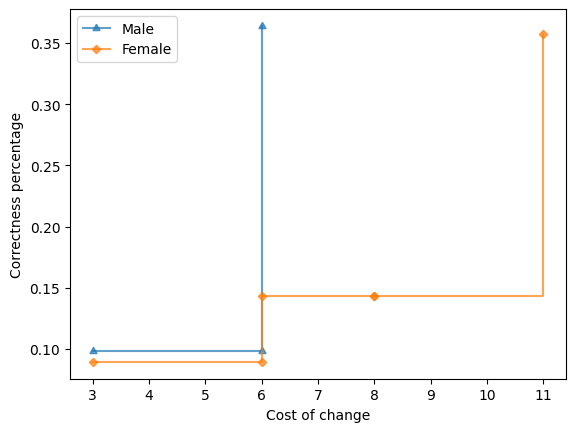

If area = Urban, college_educated = 1, homeowner = 1, parents = 0:
	Protected Subgroup 'Male', 1.35% covered out of 83563
		Make parents = 1 with effectiveness 30.79% and counterfactual cost = 3.0.
		Aggregate cost of the above recourses = 3.00
	Protected Subgroup 'Female', 1.21% covered out of 162105
		Make parents = 1 with effectiveness 0.10% and counterfactual cost = 3.0.
		Make homeowner = 0, parents = 1 with effectiveness 99.74% and counterfactual cost = 4.0.
		Aggregate cost of the above recourses = 4.00
	Bias against Female due to Equal Effectiveness. Unfairness score = 1.0.
	Cumulative effectiveness plot for the above recourses:


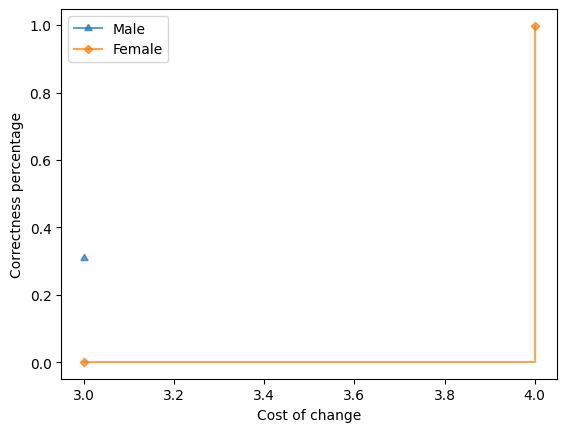

If ages = 55-64, area = Urban, college_educated = 0, homeowner = 1, parents = 1:
	Protected Subgroup 'Male', 1.34% covered out of 83563
		Make college_educated = 1 with effectiveness 30.87% and counterfactual cost = 3.0.
		Aggregate cost of the above recourses = 3.00
	Protected Subgroup 'Female', 1.22% covered out of 162105
		Make college_educated = 1 with effectiveness 0.00% and counterfactual cost = 3.0.
		Make college_educated = 1, homeowner = 0 with effectiveness 99.80% and counterfactual cost = 4.0.
		Aggregate cost of the above recourses = 4.00
	Bias against Female due to Equal Effectiveness. Unfairness score = 1.0.
	Cumulative effectiveness plot for the above recourses:


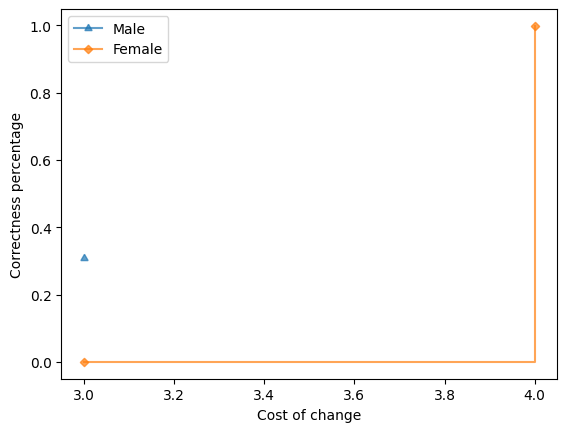

In [37]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="min-above-corr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "keep-cheap-rules-above-thr-cor",
        # "keep-only-min-change",
        
    ],
    cor_threshold = 0.3,
    params=params
)

pop_sizes = {sg: ((X_test["gender"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["gender"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

### Equal Effectiveness Within Budget

If ages = 55-64, area = Unknown, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 43.91% covered out of 83563
		Make income = <100K with effectiveness 0.00% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 94.30% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 94.30% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 100.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 100.00% and counterfactual cost = 7.0.
		Make income = <100K, religion = Christianity with effectiveness 100.00% and counterfactual cost = 8.0.
		Make income = <100K, religion = Other with effectiveness 100.00% and counterfactual cost = 8

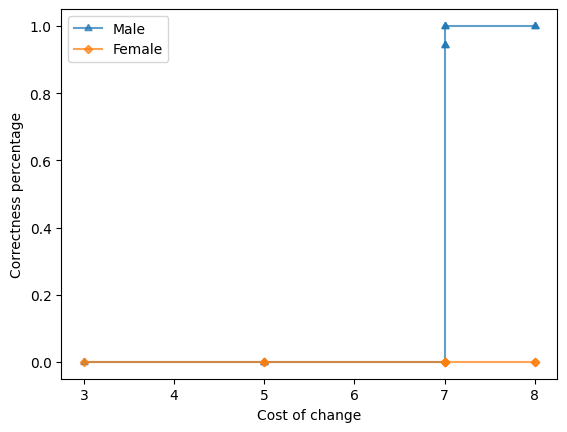

If ages = 55-64, area = Unknown, college_educated = 1, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 41.41% covered out of 83563
		Make income = <100K with effectiveness 0.00% and counterfactual cost = 3.0.
		Make college_educated = 0 with effectiveness 0.00% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 100.00% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 100.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 100.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 100.00% and counterfactual cost = 7.0.
		Make income = <100K, religion = Christianity with effectiveness 100.00% and counterfactua

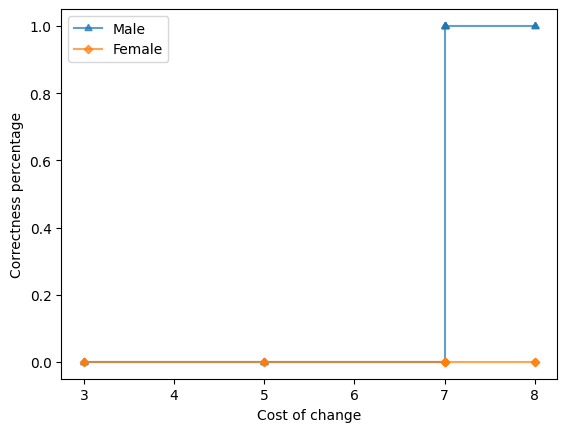

If ages = 55-64, area = Urban, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 16.00% covered out of 83563
		Make religion = Christianity with effectiveness 94.35% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 94.35% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 100.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 100.00% and counterfactual cost = 7.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Female', 14.50% covered out of 162105
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 0.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 0.00% and counterfactual cost = 7.0.
		Aggr

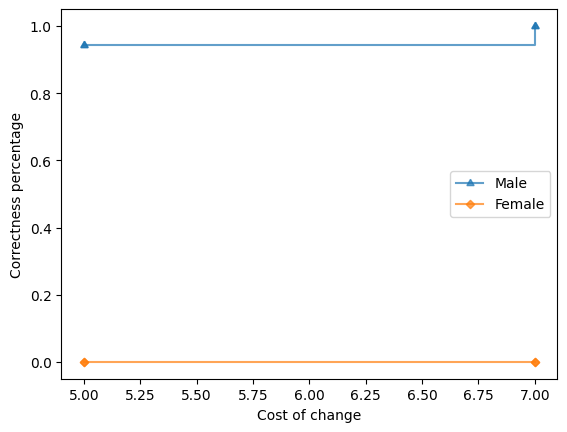

If ages = 55-64, area = Unknown, income = Unknown, parents = 1, politics = Unknown, religion = Christianity:
	Protected Subgroup 'Male', 10.31% covered out of 83563
		Make area = Urban with effectiveness 94.57% and counterfactual cost = 2.0.
		Make area = Rural with effectiveness 100.00% and counterfactual cost = 2.0.
		Make income = <100K with effectiveness 100.00% and counterfactual cost = 3.0.
		Make religion = Other with effectiveness 100.00% and counterfactual cost = 5.0.
		Make area = Urban, religion = Other with effectiveness 100.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 100.00% and counterfactual cost = 7.0.
		Make income = <100K, religion = Other with effectiveness 100.00% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Female', 9.57% covered out of 162105
		Make area = Urban with effectiveness 0.00% and counterfactual cost = 2.0.
		Make area = Rural with effectiveness 0.00% an

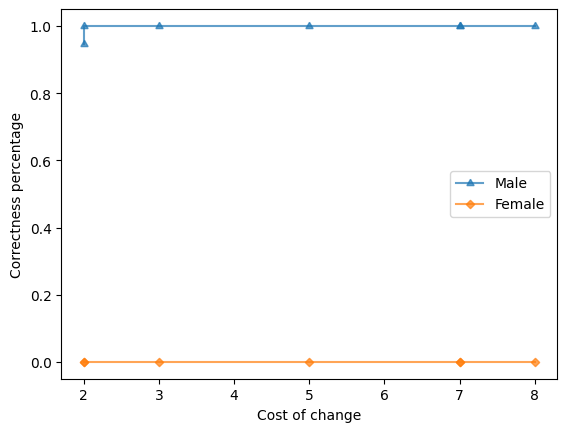

If ages = 55-64, area = Unknown, income = Unknown, parents = 1, politics = Unknown, religion = Other:
	Protected Subgroup 'Male', 9.66% covered out of 83563
		Make area = Urban with effectiveness 94.50% and counterfactual cost = 2.0.
		Make area = Rural with effectiveness 100.00% and counterfactual cost = 2.0.
		Make income = <100K with effectiveness 100.00% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 100.00% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 100.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 100.00% and counterfactual cost = 7.0.
		Make income = <100K, religion = Christianity with effectiveness 100.00% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Female', 8.67% covered out of 162105
		Make area = Urban with effectiveness 0.00% and counterfactual cost = 2.0.
		Make area = Rural with ef

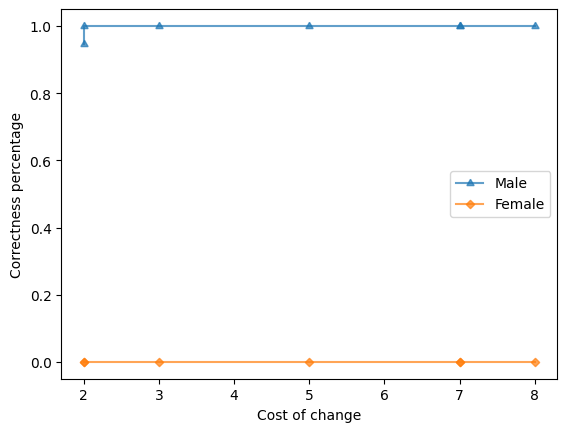

If ages = 55-64, area = Rural, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 3.42% covered out of 83563
		Make religion = Other with effectiveness 100.00% and counterfactual cost = 5.0.
		Make religion = Christianity with effectiveness 100.00% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 100.00% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 100.00% and counterfactual cost = 7.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Female', 3.03% covered out of 162105
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 0.00% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 0.00% and counterfactual cost = 7.0.
		Aggr

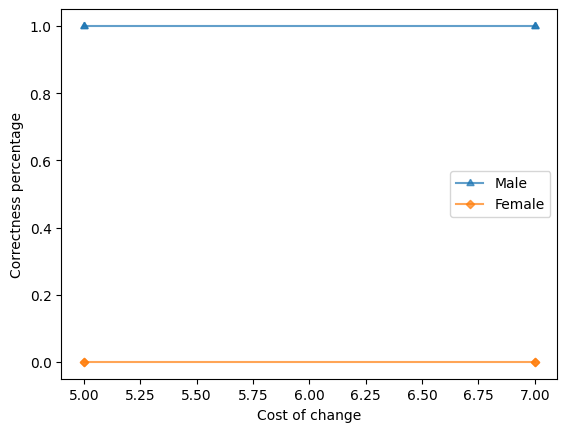

If ages = 55-64, area = Unknown, college_educated = 0, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 2.50% covered out of 83563
		Make college_educated = 1 with effectiveness 0.00% and counterfactual cost = 3.0.
		Make college_educated = 1, income = <100K with effectiveness 0.00% and counterfactual cost = 6.0.
		Make college_educated = 1, religion = Christianity with effectiveness 0.00% and counterfactual cost = 8.0.
		Make college_educated = 1, religion = Other with effectiveness 0.00% and counterfactual cost = 8.0.
		Make area = Urban, college_educated = 1, religion = Christianity with effectiveness 100.00% and counterfactual cost = 10.0.
		Make area = Urban, college_educated = 1, religion = Other with effectiveness 100.00% and counterfactual cost = 10.0.
		Make area = Rural, college_educated = 1, religion = Other with effectiveness 100.00% and counterfactual cost = 10.0.
		Make area = Rural, college_educated = 1, religion = Christ

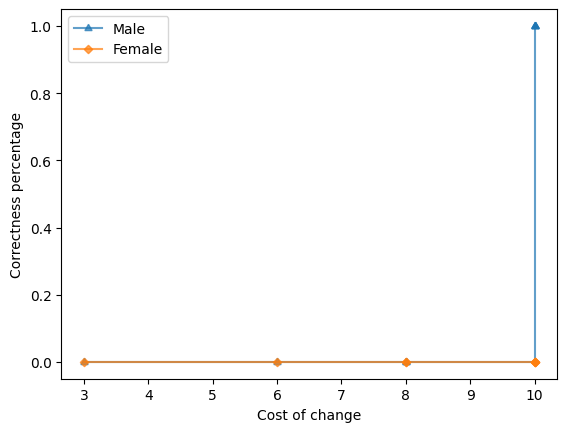

If ages = 55-64, area = Unknown, college_educated = 0, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 2.60% covered out of 83563
		Make college_educated = 1 with effectiveness 0.00% and counterfactual cost = 3.0.
		Make college_educated = 1, religion = Christianity with effectiveness 1.10% and counterfactual cost = 8.0.
		Make college_educated = 1, religion = Other with effectiveness 1.10% and counterfactual cost = 8.0.
		Make area = Urban, college_educated = 1, religion = Christianity with effectiveness 99.20% and counterfactual cost = 10.0.
		Make area = Urban, college_educated = 1, religion = Other with effectiveness 99.20% and counterfactual cost = 10.0.
		Make area = Rural, college_educated = 1, religion = Christianity with effectiveness 99.20% and counterfactual cost = 10.0.
		Make area = Rural, college_educated = 1, religion = Other with effectiveness 99.20% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.99
	Protecte

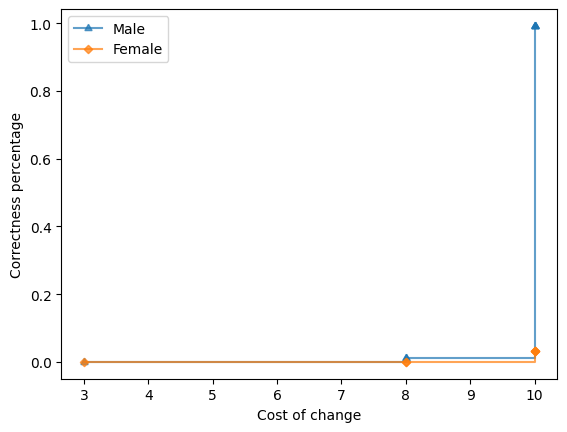

If ages = 55-64, area = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 46.07% covered out of 83563
		Make area = Urban with effectiveness 3.26% and counterfactual cost = 2.0.
		Make religion = Christianity with effectiveness 3.26% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 3.26% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 93.14% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 93.14% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 98.58% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 98.58% and counterfactual cost = 7.0.
		Aggregate cost of the above recourses = 0.99
	Protected Subgroup 'Female', 42.50% covered out of 162105
		Make area = Urban with effectiveness 1.12% and counterfactual cost = 2.0.
		Make religion = Christianity with eff

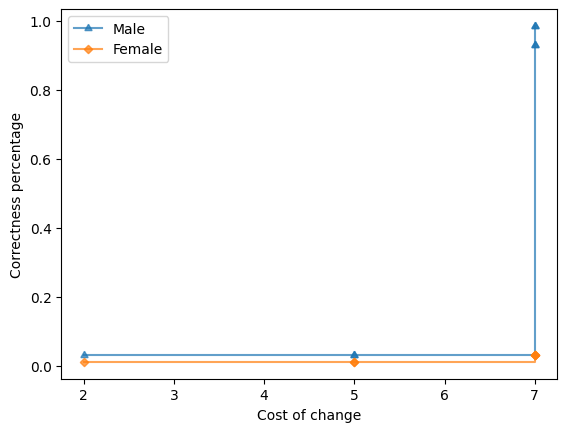

If ages = 55-64, area = Unknown, college_educated = 1, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 43.47% covered out of 83563
		Make college_educated = 0 with effectiveness 0.00% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 1.20% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 1.20% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 98.54% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 98.54% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 98.54% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 98.54% and counterfactual cost = 7.0.
		Aggregate cost of the above recourses = 0.99
	Protected Subgroup 'Female', 40.06% covered out of 162105
		Make college_educated = 0 with effectiveness 0.00% and counterfactual cost = 3.0.
	

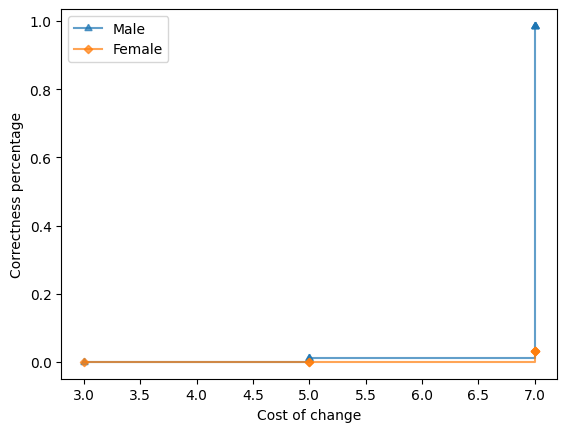

In [38]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="max-upto-cost",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-above-thr-cost"
        #"remove-below-thr",
        #"keep-only-min-change",
        
    ],
    cost_threshold = 10,
    params=params
)

pop_sizes = {sg: ((X_test["gender"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["gender"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric = True
)

### Fair Effectiveness-Cost Trade-Off

If ages = 55-64, area = Unknown, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 43.91% covered out of 83563
		Make income = <100K with effectiveness 0.00% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 94.30% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 94.30% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 100.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 100.00% and counterfactual cost = 7.0.
		Make income = <100K, religion = Christianity with effectiveness 100.00% and counterfactual cost = 8.0.
		Make income = <100K, religion = Other with effectiveness 100.00% and counterfactual cost = 8

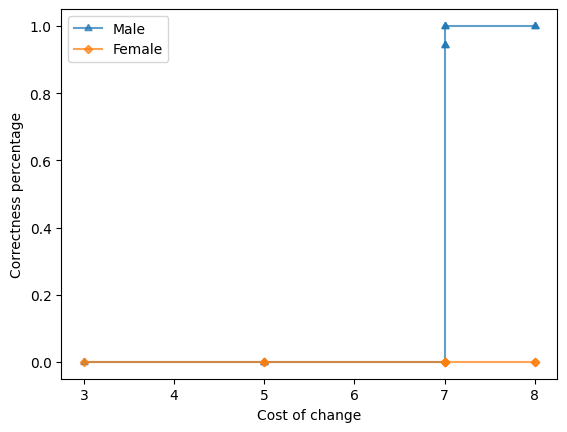

If ages = 55-64, area = Unknown, income = Unknown, parents = 1, religion = Unknown:
	Protected Subgroup 'Male', 44.12% covered out of 83563
		Make income = <100K with effectiveness 0.00% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 93.88% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 93.88% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 99.80% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 99.80% and counterfactual cost = 7.0.
		Make income = <100K, religion = Christianity with effectiveness 99.80% and counterfactual cost = 8.0.
		Make income = <100K, religion = Other with effectiveness 99.80% and counterfactual cost = 8.0.
	Protected Subgroup 

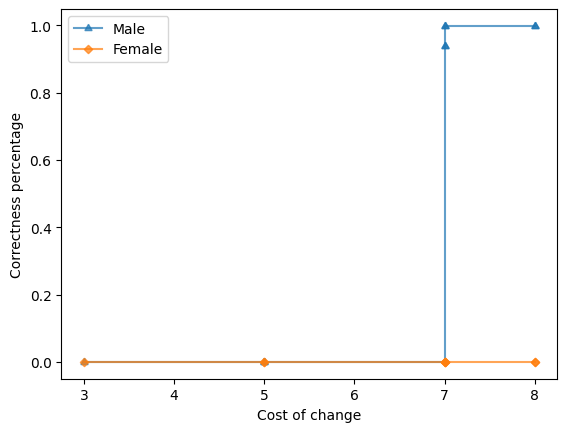

If ages = 55-64, area = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 46.07% covered out of 83563
		Make area = Urban with effectiveness 3.26% and counterfactual cost = 2.0.
		Make religion = Christianity with effectiveness 3.26% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 3.26% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 93.14% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 93.14% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 98.58% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 98.58% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 42.50% covered out of 162105
		Make area = Urban with effectiveness 1.12% and counterfactual cost = 2.0.
		Make religion = Christianity with effectiveness 1.12% and counterfactual cost = 5.0.

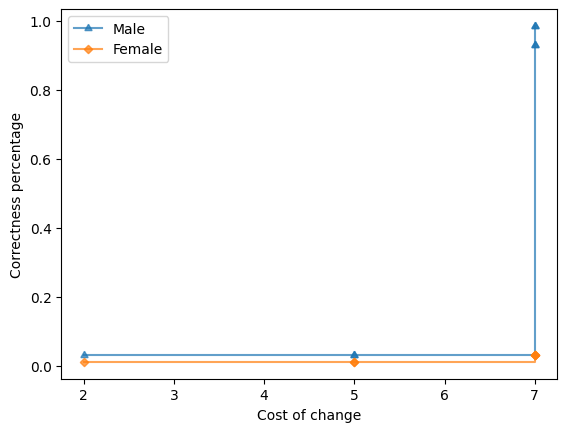

If ages = 55-64, area = Unknown, parents = 1, religion = Unknown:
	Protected Subgroup 'Male', 46.29% covered out of 83563
		Make area = Urban with effectiveness 3.24% and counterfactual cost = 2.0.
		Make religion = Christianity with effectiveness 3.24% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 3.24% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 92.73% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 92.73% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 98.38% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 98.38% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 42.73% covered out of 162105
		Make area = Urban with effectiveness 1.16% and counterfactual cost = 2.0.
		Make religion = Christianity with effectiveness 1.16% and counterfactual cost = 5.0.
		Make religion = O

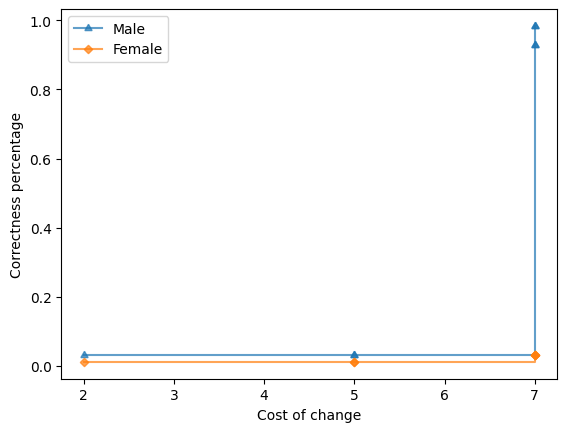

If area = Unknown, college_educated = 1, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 44.59% covered out of 83563
		Make college_educated = 0 with effectiveness 0.00% and counterfactual cost = 3.0.
		Make income = <100K with effectiveness 0.44% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 0.44% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.44% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 96.96% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 96.96% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 96.98% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 96.98% and counterfactual cost = 7.0.
		Make income = <100K, religion = Christianity with effectiveness 96.98% and counterfactual cost = 8.0.
		Mak

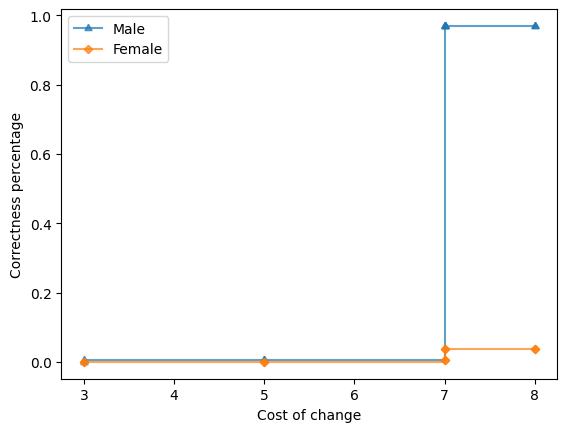

If ages = 55-64, area = Unknown, college_educated = 1, income = Unknown, parents = 1, religion = Unknown:
	Protected Subgroup 'Male', 41.60% covered out of 83563
		Make income = <100K with effectiveness 0.00% and counterfactual cost = 3.0.
		Make college_educated = 0 with effectiveness 0.00% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 99.56% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 99.56% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 99.82% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 99.82% and counterfactual cost = 7.0.
		Make income = <100K, religion = Christianity with effectiveness 99.82% and counterfactual cost = 8.0.
		Make inco

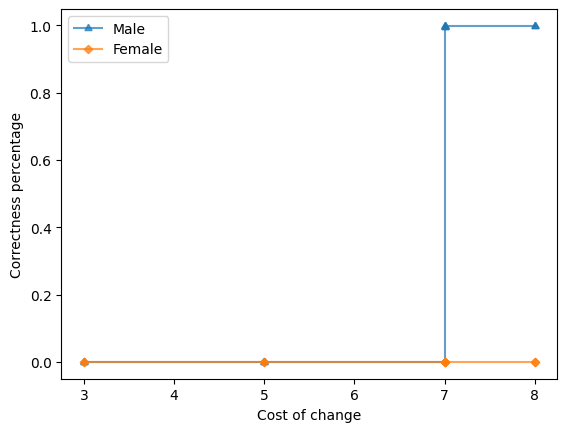

If ages = 55-64, area = Unknown, college_educated = 1, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 41.41% covered out of 83563
		Make income = <100K with effectiveness 0.00% and counterfactual cost = 3.0.
		Make college_educated = 0 with effectiveness 0.00% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 100.00% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 100.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 100.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 100.00% and counterfactual cost = 7.0.
		Make income = <100K, religion = Christianity with effectiveness 100.00% and counterfactua

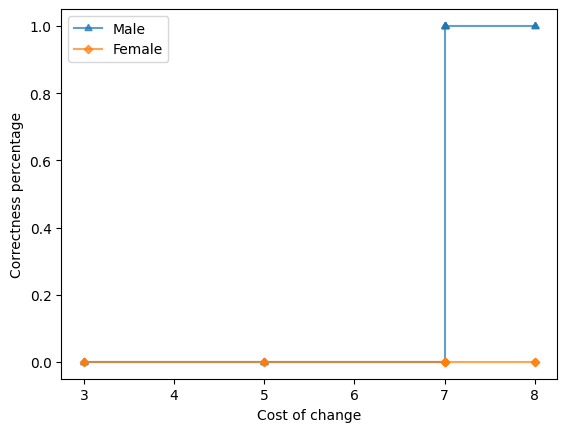

If area = Unknown, college_educated = 1, income = Unknown, parents = 1, religion = Unknown:
	Protected Subgroup 'Male', 44.79% covered out of 83563
		Make college_educated = 0 with effectiveness 0.00% and counterfactual cost = 3.0.
		Make income = <100K with effectiveness 0.44% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 0.44% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.44% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 96.56% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 96.56% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 96.82% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 96.82% and counterfactual cost = 7.0.
		Make income = <100K, religion = Christianity with effectiveness 96.82% and counterfactual cost = 8.0.
		Make income = <100K, re

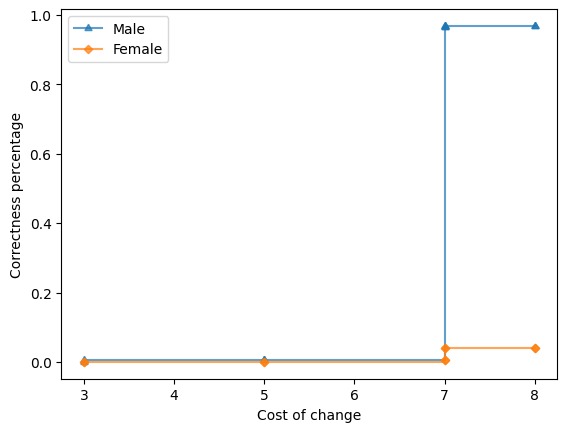

If ages = 55-64, area = Unknown, income = Unknown, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 46.86% covered out of 83563
		Make income = <100K with effectiveness 0.90% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 0.90% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.90% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 89.26% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 89.26% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 94.61% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 94.61% and counterfactual cost = 7.0.
		Make income = <100K, religion = Christianity with effectiveness 94.61% and counterfactual cost = 8.0.
		Make income = <100K, religion = Other with effectiveness 94.61% and counterfactual cost = 8.0.
	Protected Su

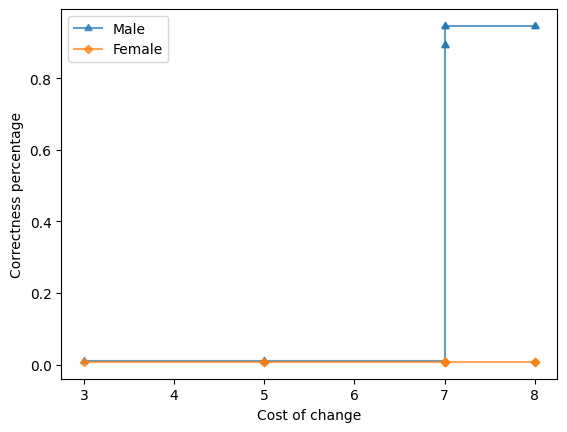

If ages = 55-64, area = Unknown, income = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 47.08% covered out of 83563
		Make income = <100K with effectiveness 0.89% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 0.89% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.89% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 88.86% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 88.86% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 94.41% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 94.41% and counterfactual cost = 7.0.
		Make income = <100K, religion = Christianity with effectiveness 94.41% and counterfactual cost = 8.0.
		Make income = <100K, religion = Other with effectiveness 94.41% and counterfactual cost = 8.0.
	Protected Subgroup 'Female', 43.

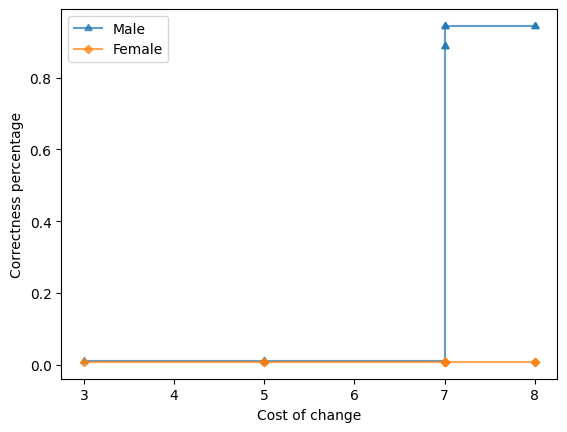

If area = Unknown, income = Unknown, parents = 1, religion = Unknown:
	Protected Subgroup 'Male', 47.48% covered out of 83563
		Make income = <100K with effectiveness 0.44% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 0.44% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.44% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 91.28% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 91.28% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 96.81% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 96.81% and counterfactual cost = 7.0.
		Make income = <100K, religion = Christianity with effectiveness 96.81% and counterfactual cost = 8.0.
		Make income = <100K, religion = Other with effectiveness 96.81% and counterfactual cost = 8.0.
	Protected Subgroup 'Female', 43.6

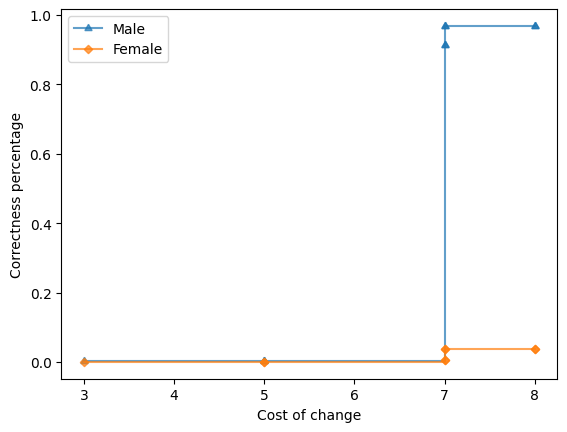

If area = Unknown, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 47.27% covered out of 83563
		Make income = <100K with effectiveness 0.44% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 0.44% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.44% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 91.67% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 91.67% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 96.99% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 96.99% and counterfactual cost = 7.0.
		Make income = <100K, religion = Christianity with effectiveness 96.99% and counterfactual cost = 8.0.
		Make income = <100K, religion = Other with effectiveness 96.99% and counterfactual cost = 8.0.
	Protected Sub

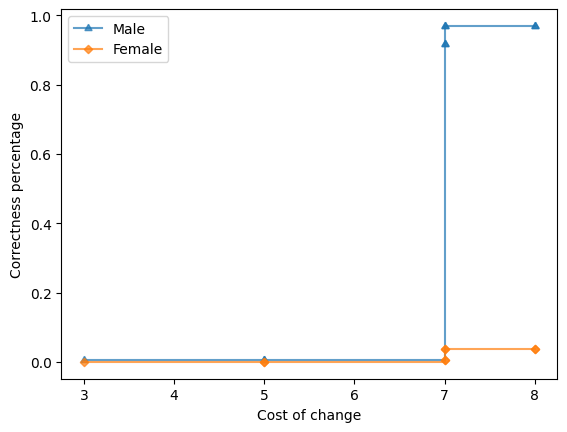

If area = Unknown, college_educated = 1, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 46.77% covered out of 83563
		Make area = Urban with effectiveness 3.54% and counterfactual cost = 2.0.
		Make college_educated = 0 with effectiveness 3.54% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 3.54% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 3.54% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 95.59% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 95.59% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 95.61% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 95.61% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 43.01% covered out of 162105
		Make area = Urban with effectiveness 1.59% and counterfactual cost =

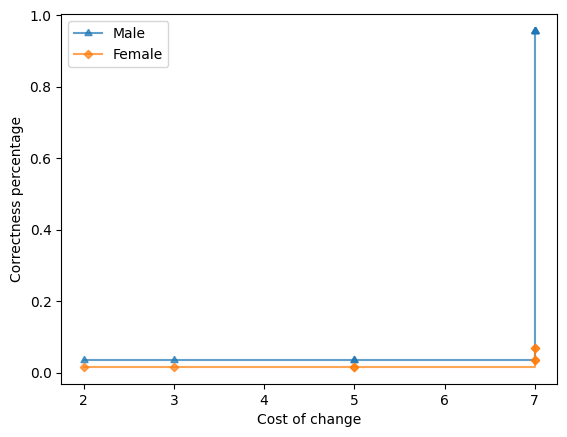

If ages = 55-64, area = Unknown, college_educated = 1, parents = 1, religion = Unknown:
	Protected Subgroup 'Male', 43.67% covered out of 83563
		Make area = Urban with effectiveness 3.26% and counterfactual cost = 2.0.
		Make college_educated = 0 with effectiveness 3.26% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 3.26% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 3.26% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 98.11% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 98.11% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 98.36% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 98.36% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 40.27% covered out of 162105
		Make area = Urban with effectiveness 1.14% and counterfactual cost = 2.0.


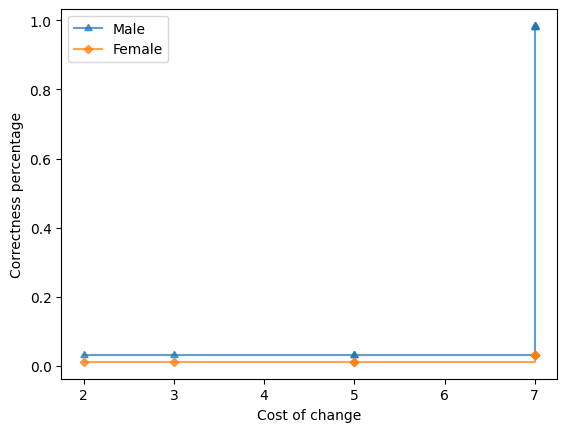

If ages = 55-64, area = Unknown, college_educated = 1, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 43.47% covered out of 83563
		Make college_educated = 0 with effectiveness 0.00% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 1.20% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 1.20% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 98.54% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 98.54% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 98.54% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 98.54% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 40.06% covered out of 162105
		Make college_educated = 0 with effectiveness 0.00% and counterfactual cost = 3.0.
		Make religion = Christianity with effectivenes

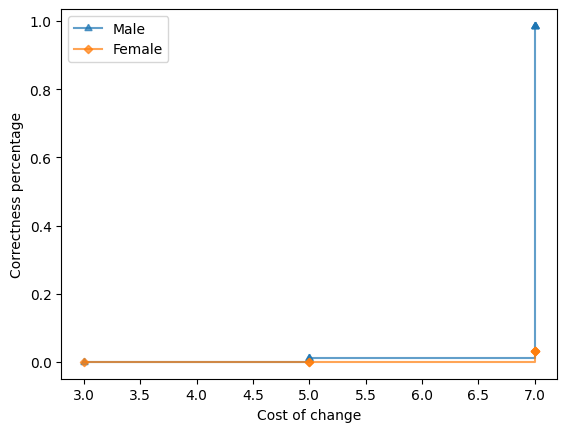

If ages = 55-64, area = Unknown, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 49.14% covered out of 83563
		Make area = Urban with effectiveness 3.91% and counterfactual cost = 2.0.
		Make religion = Christianity with effectiveness 3.91% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 3.91% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 88.24% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 88.24% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 93.44% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 93.44% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 45.29% covered out of 162105
		Make area = Urban with effectiveness 1.80% and counterfactual cost = 2.0.
		Make religion = Christianity with effectiveness 1.80% and counterfactual cost = 5.0.
		Make relig

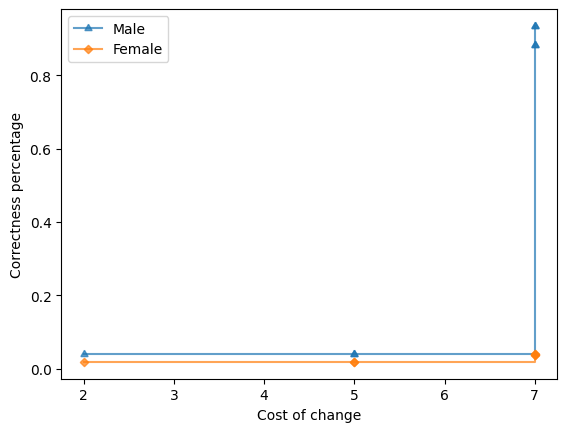

If ages = 55-64, area = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 49.38% covered out of 83563
		Make area = Urban with effectiveness 3.89% and counterfactual cost = 2.0.
		Make religion = Christianity with effectiveness 3.89% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 3.89% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 87.84% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 87.84% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 93.24% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 93.24% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 45.54% covered out of 162105
		Make area = Urban with effectiveness 1.83% and counterfactual cost = 2.0.
		Make religion = Christianity with effectiveness 1.83% and counterfactual cost = 5.0.
		Make religion = Other with eff

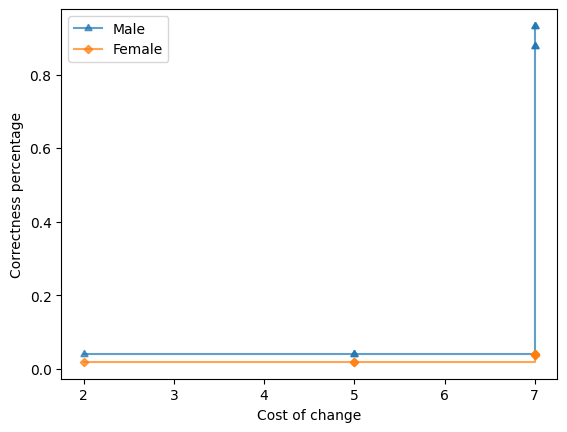

If area = Unknown, college_educated = 1, parents = 1, religion = Unknown:
	Protected Subgroup 'Male', 46.98% covered out of 83563
		Make area = Urban with effectiveness 3.53% and counterfactual cost = 2.0.
		Make college_educated = 0 with effectiveness 3.53% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 3.53% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 3.53% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 95.19% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 95.19% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 95.44% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 95.44% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 43.24% covered out of 162105
		Make area = Urban with effectiveness 1.62% and counterfactual cost = 2.0.
		Make college

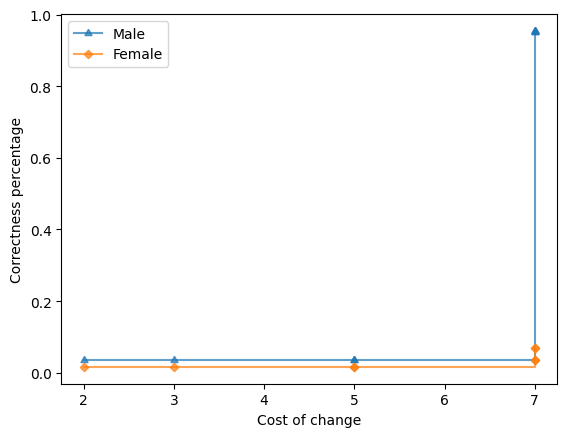

If area = Unknown, parents = 1, religion = Unknown:
	Protected Subgroup 'Male', 49.79% covered out of 83563
		Make area = Urban with effectiveness 3.52% and counterfactual cost = 2.0.
		Make religion = Christianity with effectiveness 3.52% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 3.52% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 90.19% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 90.19% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 95.46% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 95.46% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 45.86% covered out of 162105
		Make area = Urban with effectiveness 1.60% and counterfactual cost = 2.0.
		Make religion = Christianity with effectiveness 1.60% and counterfactual cost = 5.0.
		Make religion = Other with effe

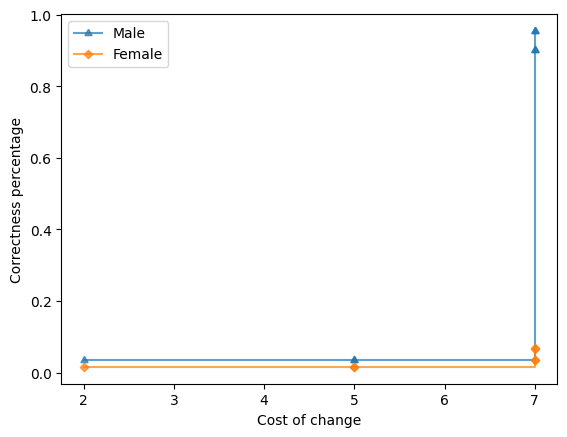

If area = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 49.56% covered out of 83563
		Make area = Urban with effectiveness 3.53% and counterfactual cost = 2.0.
		Make religion = Christianity with effectiveness 3.53% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 3.53% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 90.56% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 90.56% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 95.63% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 95.63% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 45.62% covered out of 162105
		Make area = Urban with effectiveness 1.57% and counterfactual cost = 2.0.
		Make religion = Christianity with effectiveness 1.57% and counterfactual cost = 5.0.
		Make religi

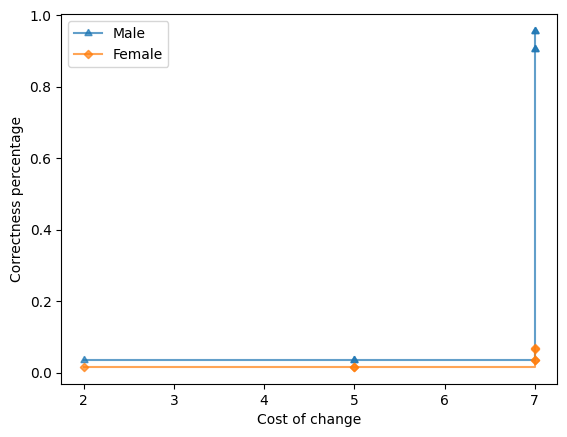

If area = Unknown, college_educated = 1, income = Unknown, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 47.54% covered out of 83563
		Make college_educated = 0 with effectiveness 0.00% and counterfactual cost = 3.0.
		Make income = <100K with effectiveness 1.24% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 1.24% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 1.24% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 91.80% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 91.80% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 91.82% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 91.82% and counterfactual cost = 7.0.
		Make income = <100K, religion = Christianity with effectiveness 91.82% and counterfactual cost = 8.0.
		Make income = <1

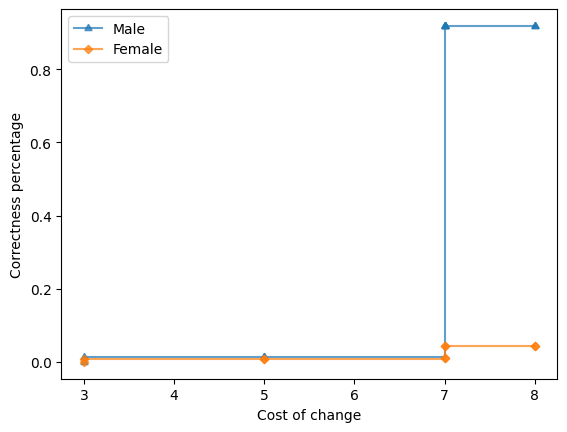

If ages = 55-64, area = Unknown, college_educated = 1, income = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 44.39% covered out of 83563
		Make college_educated = 0 with effectiveness 0.00% and counterfactual cost = 3.0.
		Make income = <100K with effectiveness 0.89% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 0.89% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.89% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 94.20% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 94.20% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 94.44% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 94.44% and counterfactual cost = 7.0.
		Make income = <100K, religion = Christianity with effectiveness 94.44% and counterfactual cost = 8.0.
		Make income = <100K, r

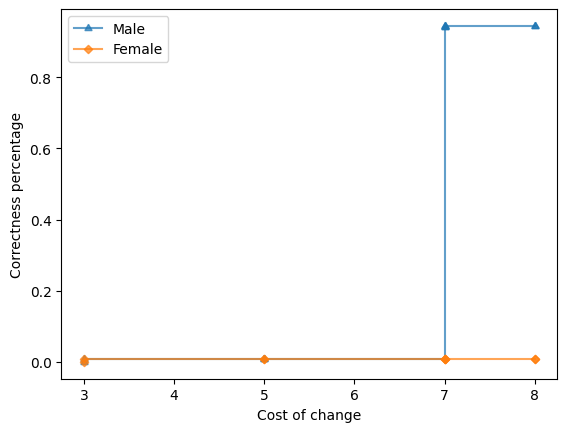

If ages = 55-64, area = Unknown, college_educated = 1, income = Unknown, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 44.18% covered out of 83563
		Make college_educated = 0 with effectiveness 0.00% and counterfactual cost = 3.0.
		Make income = <100K with effectiveness 0.89% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 0.89% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.89% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 94.63% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 94.63% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 94.63% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 94.63% and counterfactual cost = 7.0.
		Make income = <100K, religion = Christianity with effectiveness 94.63% and counterfactual cost = 8.0.
		Ma

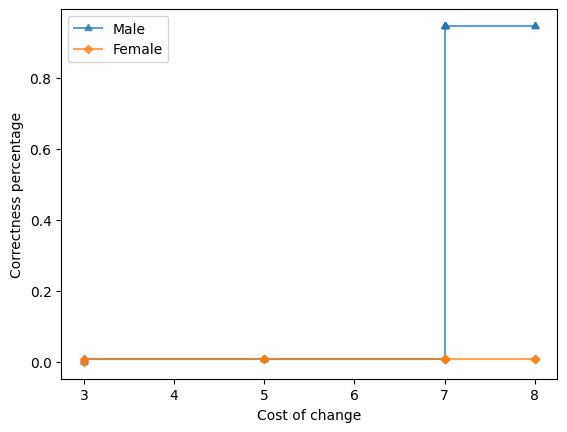

If area = Unknown, college_educated = 1, income = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 47.76% covered out of 83563
		Make college_educated = 0 with effectiveness 0.00% and counterfactual cost = 3.0.
		Make income = <100K with effectiveness 1.24% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 1.24% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 1.24% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 91.40% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 91.40% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 91.65% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 91.65% and counterfactual cost = 7.0.
		Make income = <100K, religion = Christianity with effectiveness 91.65% and counterfactual cost = 8.0.
		Make income = <100K, religion = Othe

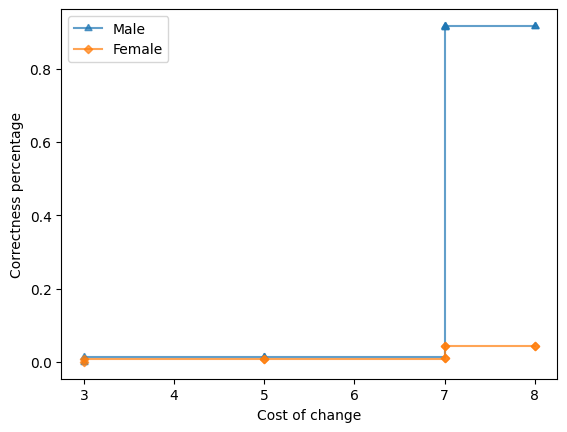

If area = Unknown, income = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 50.65% covered out of 83563
		Make income = <100K with effectiveness 1.25% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 1.25% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 1.25% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 86.44% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 86.44% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 91.62% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 91.62% and counterfactual cost = 7.0.
		Make income = <100K, religion = Christianity with effectiveness 91.62% and counterfactual cost = 8.0.
		Make income = <100K, religion = Other with effectiveness 91.62% and counterfactual cost = 8.0.
	Protected Subgroup 'Female', 46.53% covered ou

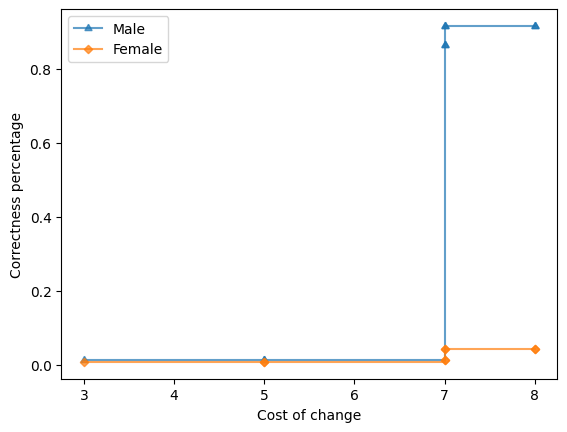

If area = Unknown, income = Unknown, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 50.41% covered out of 83563
		Make income = <100K with effectiveness 1.25% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 1.25% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 1.25% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 86.82% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 86.82% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 91.80% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 91.80% and counterfactual cost = 7.0.
		Make income = <100K, religion = Christianity with effectiveness 91.80% and counterfactual cost = 8.0.
		Make income = <100K, religion = Other with effectiveness 91.80% and counterfactual cost = 8.0.
	Protected Subgroup 'Female

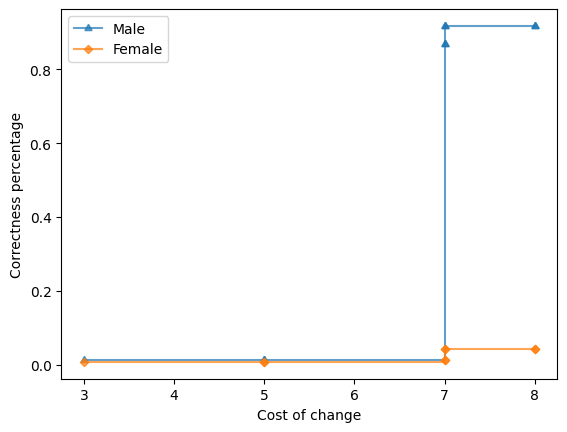

If area = Unknown, college_educated = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 49.86% covered out of 83563
		Make area = Urban with effectiveness 4.12% and counterfactual cost = 2.0.
		Make college_educated = 0 with effectiveness 4.12% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 4.12% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 4.12% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 90.56% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 90.56% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 90.68% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 90.68% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 45.81% covered out of 162105
		Make area = Urban with effectiveness 2.22% and counterfactual cost = 2.0.
		Make 

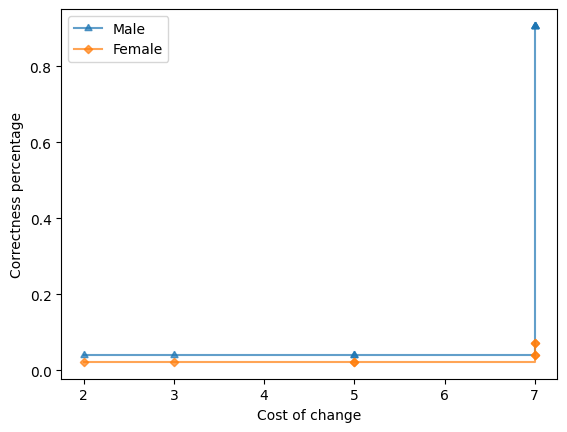

If ages = 55-64, area = Unknown, college_educated = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 46.35% covered out of 83563
		Make area = Urban with effectiveness 3.92% and counterfactual cost = 2.0.
		Make college_educated = 0 with effectiveness 3.92% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 3.92% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 3.92% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 93.32% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 93.32% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 93.43% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 93.43% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 42.69% covered out of 162105
		Make area = Urban with effectiveness 1.78% and counterfactual cost 

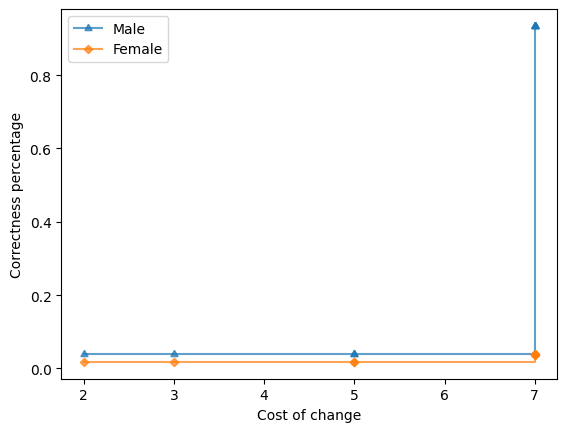

If ages = 55-64, area = Unknown, college_educated = 1, religion = Unknown:
	Protected Subgroup 'Male', 46.57% covered out of 83563
		Make area = Urban with effectiveness 3.90% and counterfactual cost = 2.0.
		Make college_educated = 0 with effectiveness 3.90% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 3.90% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 3.90% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 92.90% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 92.90% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 93.24% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 93.24% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 42.92% covered out of 162105
		Make area = Urban with effectiveness 1.81% and counterfactual cost = 2.0.
		Make colleg

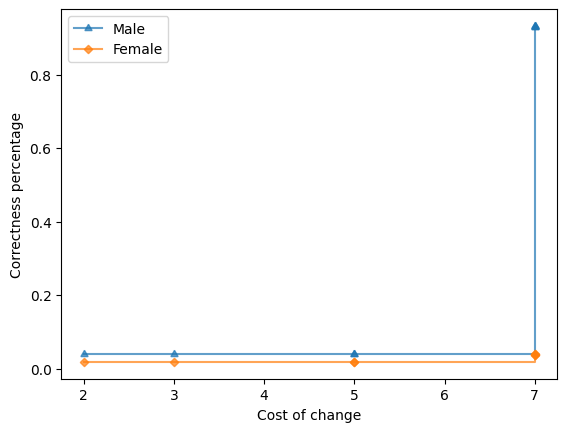

If area = Unknown, college_educated = 1, religion = Unknown:
	Protected Subgroup 'Male', 50.09% covered out of 83563
		Make area = Urban with effectiveness 4.11% and counterfactual cost = 2.0.
		Make college_educated = 0 with effectiveness 4.11% and counterfactual cost = 3.0.
		Make religion = Christianity with effectiveness 4.11% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 4.11% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 90.18% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 90.18% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 90.52% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 90.52% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 46.06% covered out of 162105
		Make area = Urban with effectiveness 2.24% and counterfactual cost = 2.0.
		Make college_educated = 0

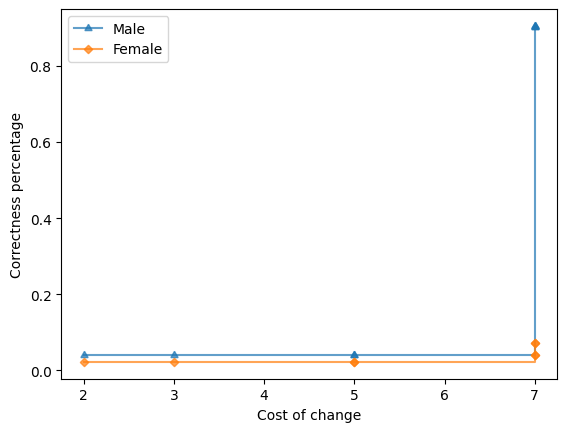

If area = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 53.09% covered out of 83563
		Make area = Urban with effectiveness 4.11% and counterfactual cost = 2.0.
		Make religion = Christianity with effectiveness 4.11% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 4.11% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 85.47% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 85.47% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 90.52% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 90.52% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 48.86% covered out of 162105
		Make area = Urban with effectiveness 2.23% and counterfactual cost = 2.0.
		Make religion = Christianity with effectiveness 2.23% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 2.2

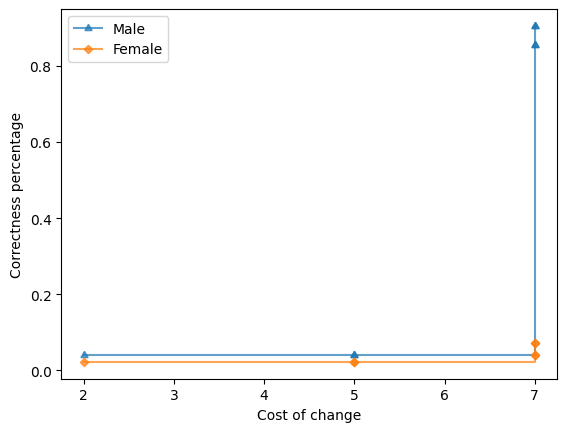

If area = Unknown, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 52.84% covered out of 83563
		Make area = Urban with effectiveness 4.12% and counterfactual cost = 2.0.
		Make religion = Christianity with effectiveness 4.12% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 4.12% and counterfactual cost = 5.0.
		Make area = Urban, religion = Christianity with effectiveness 85.84% and counterfactual cost = 7.0.
		Make area = Urban, religion = Other with effectiveness 85.84% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 90.70% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 90.70% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 48.60% covered out of 162105
		Make area = Urban with effectiveness 2.20% and counterfactual cost = 2.0.
		Make religion = Christianity with effectiveness 2.20% and counterfactual cost = 5.0.
		Make religion = Other wi

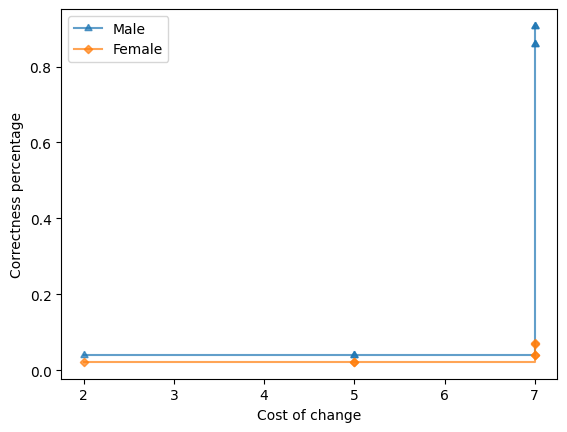

If ages = 55-64, area = Urban, homeowner = 1, income = Unknown, parents = 1, religion = Unknown:
	Protected Subgroup 'Male', 16.09% covered out of 83563
		Make religion = Christianity with effectiveness 93.81% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 93.81% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 99.80% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 99.80% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 14.57% covered out of 162105
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 0.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 0.00% and counterfactual cost = 7.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off 

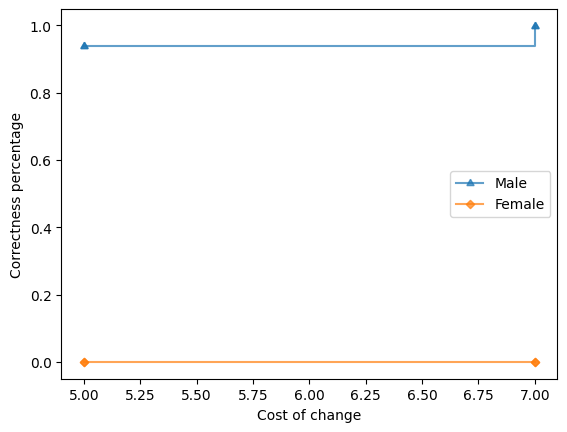

If ages = 55-64, area = Urban, income = Unknown, parents = 1, religion = Unknown:
	Protected Subgroup 'Male', 16.09% covered out of 83563
		Make religion = Christianity with effectiveness 93.81% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 93.81% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 99.80% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 99.80% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 14.57% covered out of 162105
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 0.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 0.00% and counterfactual cost = 7.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 92.38.
	Cumul

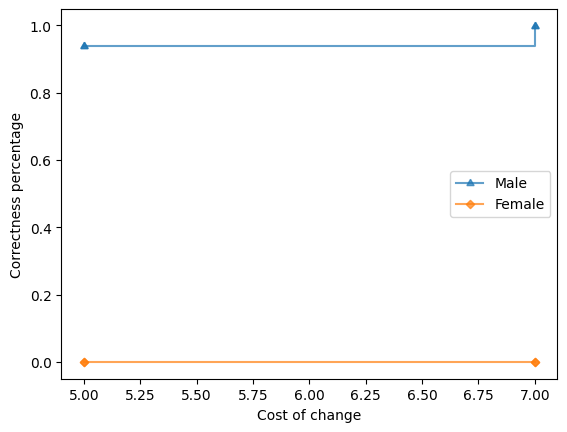

If ages = 55-64, area = Urban, homeowner = 1, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 16.00% covered out of 83563
		Make religion = Christianity with effectiveness 94.35% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 94.35% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 100.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 100.00% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 14.50% covered out of 162105
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 0.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 0.00% and counterfactual cost = 7.0.
	 Unfairness based on the Fair Effecti

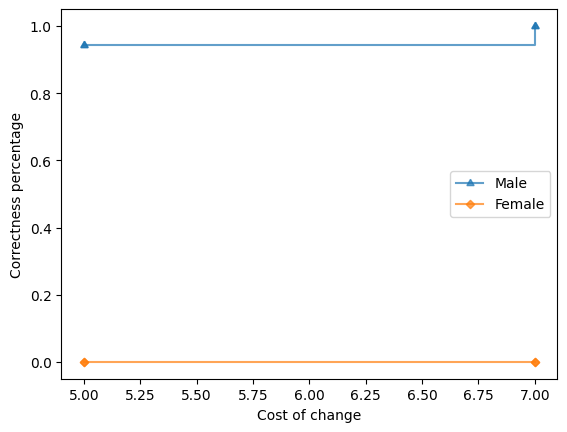

If ages = 55-64, area = Urban, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 16.00% covered out of 83563
		Make religion = Christianity with effectiveness 94.35% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 94.35% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 100.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 100.00% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 14.50% covered out of 162105
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 0.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 0.00% and counterfactual cost = 7.0.
	 Unfairness based on the Fair Effectiveness-Cost Tra

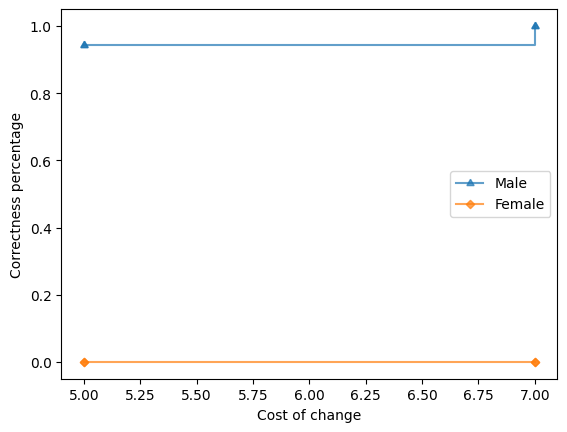

If ages = 55-64, area = Urban, homeowner = 1, parents = 1, religion = Unknown:
	Protected Subgroup 'Male', 16.22% covered out of 83563
		Make religion = Christianity with effectiveness 93.08% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 93.08% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 99.02% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 99.02% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 14.77% covered out of 162105
		Make religion = Christianity with effectiveness 0.71% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.71% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 0.71% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 0.71% and counterfactual cost = 7.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 91.45.
	Cumulati

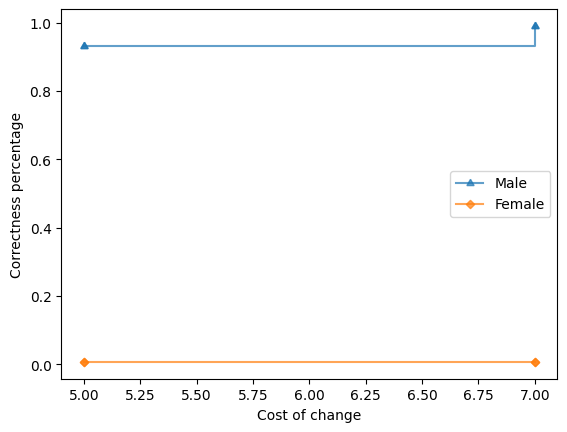

If ages = 55-64, area = Urban, parents = 1, religion = Unknown:
	Protected Subgroup 'Male', 16.22% covered out of 83563
		Make religion = Christianity with effectiveness 93.08% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 93.08% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 99.02% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 99.02% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 14.77% covered out of 162105
		Make religion = Christianity with effectiveness 0.71% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.71% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 0.72% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 0.72% and counterfactual cost = 7.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 91.44.
	Cumulative effectivenes

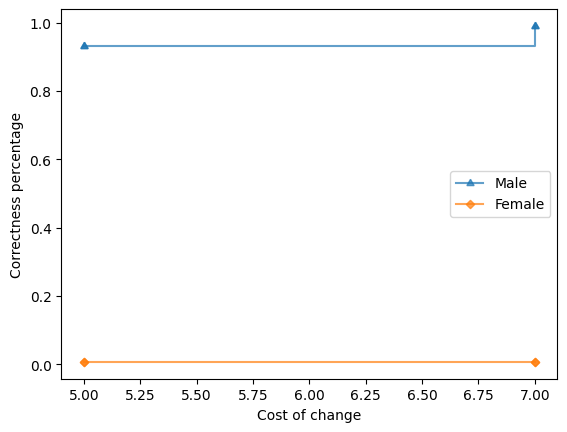

If ages = 55-64, area = Urban, homeowner = 1, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 16.12% covered out of 83563
		Make religion = Christianity with effectiveness 93.62% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 93.62% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 99.22% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 99.22% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 14.70% covered out of 162105
		Make religion = Christianity with effectiveness 0.71% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.71% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 0.71% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 0.71% and counterfactual cost = 7.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Of

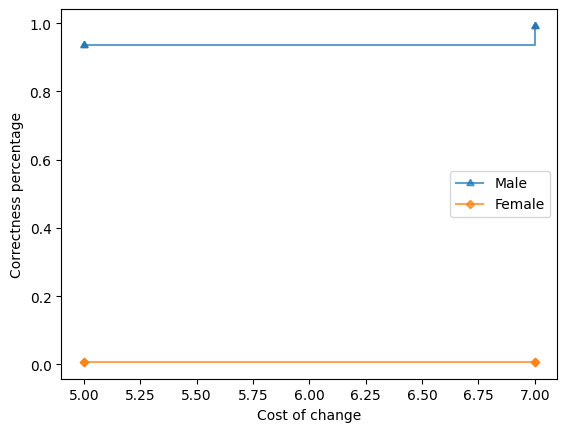

If ages = 55-64, area = Urban, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 16.12% covered out of 83563
		Make religion = Christianity with effectiveness 93.62% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 93.62% and counterfactual cost = 5.0.
		Make area = Rural, religion = Christianity with effectiveness 99.22% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 99.22% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 14.70% covered out of 162105
		Make religion = Christianity with effectiveness 0.71% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.71% and counterfactual cost = 5.0.
		Make area = Rural, religion = Christianity with effectiveness 0.71% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 0.71% and counterfactual cost = 7.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 91.39.
	Cum

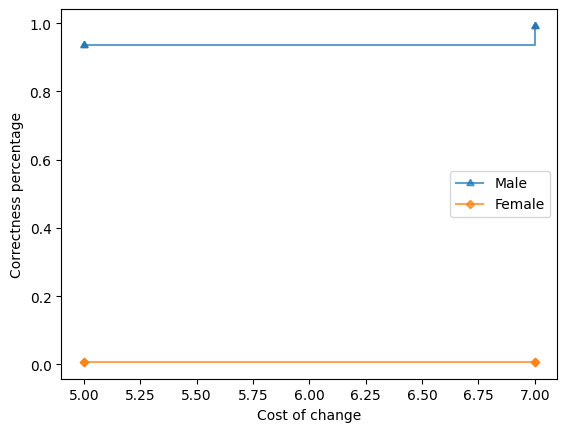

If area = Urban, college_educated = 1, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 16.19% covered out of 83563
		Make religion = Christianity with effectiveness 97.03% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 97.03% and counterfactual cost = 5.0.
		Make area = Rural, religion = Christianity with effectiveness 97.03% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 97.03% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 14.61% covered out of 162105
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Rural, religion = Christianity with effectiveness 3.61% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 3.61% and counterfactual cost = 7.0.
	 Unfairness based on the Fair Effectiveness-Co

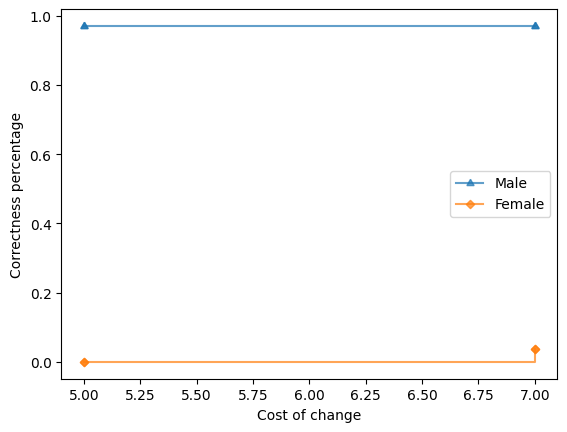

If area = Urban, college_educated = 1, homeowner = 1, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 16.19% covered out of 83563
		Make religion = Christianity with effectiveness 97.03% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 97.03% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 97.03% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 97.03% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 14.61% covered out of 162105
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 3.61% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 3.61% and counterfactual cost = 7.0.
	 Unfairness based on the Fair E

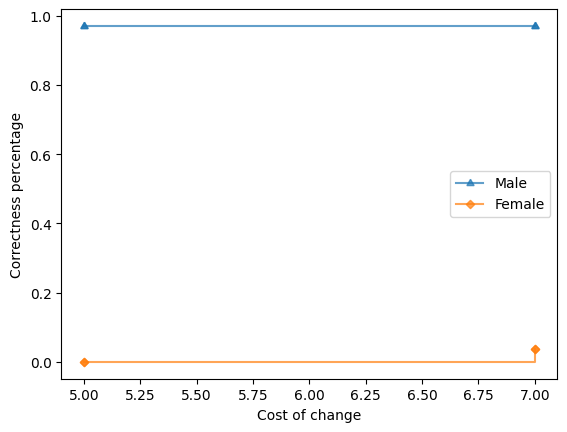

If ages = 55-64, area = Urban, homeowner = 1, income = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 17.00% covered out of 83563
		Make religion = Christianity with effectiveness 88.77% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 88.77% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 94.43% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 94.43% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 15.40% covered out of 162105
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 0.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 0.00% and counterfactual cost = 7.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 89.85.
	Cum

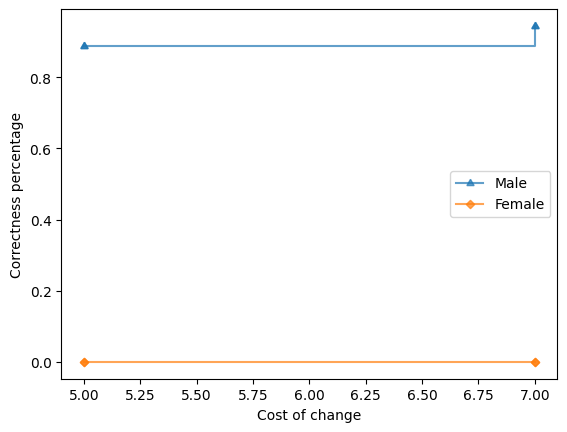

If ages = 55-64, area = Urban, income = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 17.00% covered out of 83563
		Make religion = Christianity with effectiveness 88.77% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 88.77% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 94.43% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 94.43% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 15.40% covered out of 162105
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 0.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 0.00% and counterfactual cost = 7.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 89.85.
	Cumulative effecti

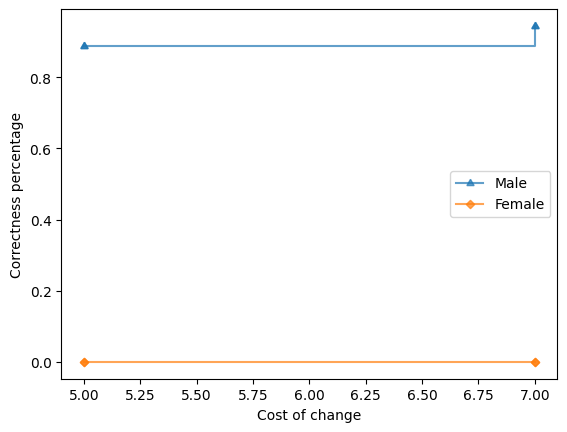

If area = Urban, college_educated = 1, income = Unknown, parents = 1, religion = Unknown:
	Protected Subgroup 'Male', 16.27% covered out of 83563
		Make religion = Christianity with effectiveness 96.53% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 96.53% and counterfactual cost = 5.0.
		Make area = Rural, religion = Christianity with effectiveness 96.89% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 96.89% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 14.68% covered out of 162105
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Rural, religion = Christianity with effectiveness 3.59% and counterfactual cost = 7.0.
		Make area = Rural, religion = Other with effectiveness 3.59% and counterfactual cost = 7.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 89.79

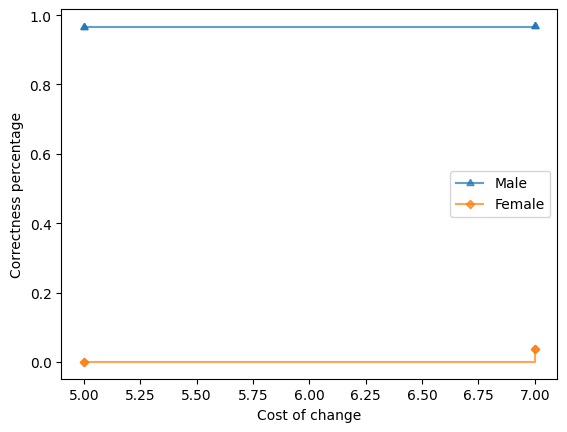

If area = Urban, college_educated = 1, homeowner = 1, income = Unknown, parents = 1, religion = Unknown:
	Protected Subgroup 'Male', 16.27% covered out of 83563
		Make religion = Christianity with effectiveness 96.53% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 96.53% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 96.89% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 96.89% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 14.68% covered out of 162105
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 3.59% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 3.59% and counterfactual cost = 7.0.
	 Unfairness based on the Fair Effectiveness-Cost Tr

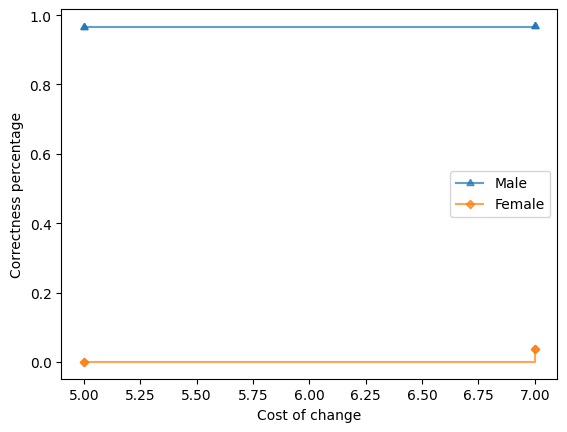

If ages = 55-64, area = Urban, homeowner = 1, income = Unknown, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 16.91% covered out of 83563
		Make religion = Christianity with effectiveness 89.28% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 89.28% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 94.62% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 94.62% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 15.32% covered out of 162105
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 0.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 0.00% and counterfactual cost = 7.0.
	 Unfairness based on the Fair Effectiveness-Cost Tra

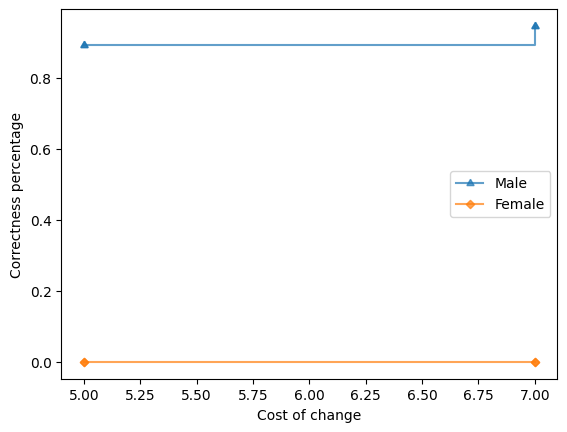

If ages = 55-64, area = Urban, income = Unknown, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 16.91% covered out of 83563
		Make religion = Christianity with effectiveness 89.28% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 89.28% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 94.62% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 94.62% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 15.32% covered out of 162105
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 0.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 0.00% and counterfactual cost = 7.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 89.79.

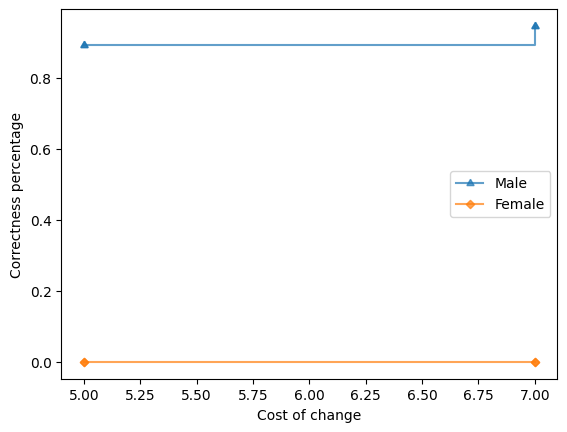

If ages = 55-64, area = Urban, college_educated = 1, income = Unknown, parents = 1, religion = Unknown:
	Protected Subgroup 'Male', 15.18% covered out of 83563
		Make religion = Christianity with effectiveness 99.45% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 99.45% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 99.84% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 99.84% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 13.75% covered out of 162105
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 0.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 0.00% and counterfactual cost = 7.0.
	 Unfairness based on the Fair Effectiveness-Cost Tra

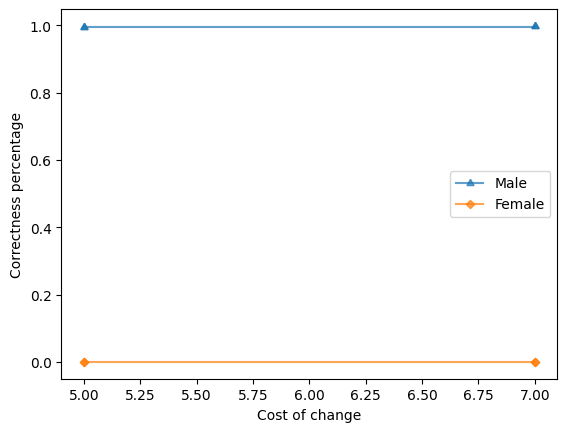

If ages = 55-64, area = Urban, college_educated = 1, homeowner = 1, income = Unknown, parents = 1, religion = Unknown:
	Protected Subgroup 'Male', 15.18% covered out of 83563
		Make religion = Christianity with effectiveness 99.45% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 99.45% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 99.84% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 99.84% and counterfactual cost = 7.0.
	Protected Subgroup 'Female', 13.75% covered out of 162105
		Make religion = Christianity with effectiveness 0.00% and counterfactual cost = 5.0.
		Make religion = Other with effectiveness 0.00% and counterfactual cost = 5.0.
		Make area = Rural, religion = Other with effectiveness 0.00% and counterfactual cost = 7.0.
		Make area = Rural, religion = Christianity with effectiveness 0.00% and counterfactual cost = 7.0.
	 Unfairness based on the Fair Effecti

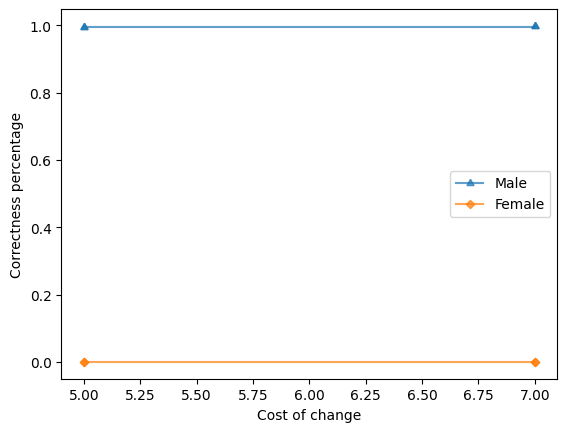

In [39]:
affected_pop_sizes = {sg: ((X_test["gender"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["gender"].unique()}

top_rules,unfairness = facts.select_rules_subset_KStest(
    rules_with_cumulative,
    affected_pop_sizes,
    top_count=50
)

print_recourse_report_KStest_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    unfairness = unfairness,
    show_then_costs=True,
    show_cumulative_plots=True
)